# Imports and setup

Want to rerun with smaller grid size for this stream since it is less long than GD-1. Is this something we have to change for each stream or is there a value that would be small enough for Pal 5 and still be ok for GD-1?

In [1]:
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmasher as cmr

%matplotlib inline
import numpy as np
import gala.coordinates as gc

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jaxopt

import arviz as az
import numpyro

from scipy.stats import binned_statistic
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

numpyro.enable_x64()
numpyro.set_host_device_count(2)
#from numpyro_ext.optim import optimize

import sys
sys.path.append('/Users/Tavangar/Work/stream-membership/')
sys.path.append('../../')
sys.path.append('/Users/Tavangar/Work/CATS_workshop/cats/')
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections
from gd1_helpers.membership.gd1_model import (
    Base,
    BackgroundModel,
    StreamDensModel,
    OffTrackModel,
)

from scripts.m92_init import *

from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

/Users/Tavangar/anaconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


In [2]:
cmap = plt.get_cmap('cmr.ember_r')
mpl.rc('image', cmap=cmap.name)

In [3]:
import importlib
importlib.reload(sys.modules['gd1_helpers.membership'])
importlib.reload(sys.modules['gd1_helpers.membership.gd1_model'])
importlib.reload(sys.modules['stream_membership'])
importlib.reload(sys.modules['scripts'])
from gd1_helpers.membership.gd1_model import (
    Base,
    BackgroundModel,
    StreamDensModel,
    OffTrackModel,
)
from scripts.m92_init import *
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections

In [4]:
data = at.Table.read("/Users/Tavangar/Work/CATS_Workshop/cats/data/joined-M92.fits")

#data = at.Table.read('../data/tmp/run_data.fits')
#masks = at.Table.read('../data/tmp/run_data_masks.fits')
cat = data
cat['pm1'] = cat['pm_phi1_cosphi2_unrefl']
cat['pm2'] = cat['pm_phi2_unrefl']

stream='M92'
phi1_lim = (np.min(cat['phi1']), np.max(cat['phi1']))
phi1_lim = [-10,10]

cat = cat[(cat['phi1'] < phi1_lim[1]) & (cat['phi1'] > phi1_lim[0])] # clunky to hard code this

In [5]:
m92_dict = dict(
                # galstream stuff
                short_name="M92",
                pawprint_id='ibata2021',
                #pawprint_id="thomas2020",
                # stream stuff
                width=2,  # TOTAL width degrees, recommend 2sigma if known
                # data stuff
                phot_survey="PS1",
                band1="g",
                band2="i",
                mag="g_0",
                color1="g_0",
                color2="i_0",
                minmag=16.0,
                maxmag=24.0,
                # isochrone stuff
                age=13,  # Gyr
                feh=-1.98,
                distance=8.5,  # kpc
                turnoff=18,  # bright limit of polygon (default should be MS turnoff)
                alpha=0,  # don't think we actually use this
                scale_err=2,
                base_err=0.075,
                bin_sizes=[0.03, 0.2],
            )

In [6]:
import importlib
importlib.reload(sys.modules['cats.pawprint.pawprint'])
importlib.reload(sys.modules['cats.CMD'])
importlib.reload(sys.modules['cats.proper_motions'])
from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

p = Pawprint.pawprint_from_galstreams(m92_dict['short_name'],
                                      m92_dict['pawprint_id'],
                                      width=4 * u.deg,
                                      phi1_lim=phi1_lim)

# rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=2)

# Create the CMD cuts
o = Isochrone(cat, m92_dict, pawprint=p)
_, iso_mask, _, hb_mask, pprint = o.simpleSln(maxmag=22, mass_thresh=0.83)

Modifying/extrapolating galstreams track
Modifying/extrapolating galstreams track


-0.17116191762005428
Fitting for peak pm location
Pre-fitting mean PM values: -3.709, -3.152
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [-3.8589537124551043, -3.1597635677071927, 0.34556303569703034, 0.31219462087291167] 

Producing the polygon and mask


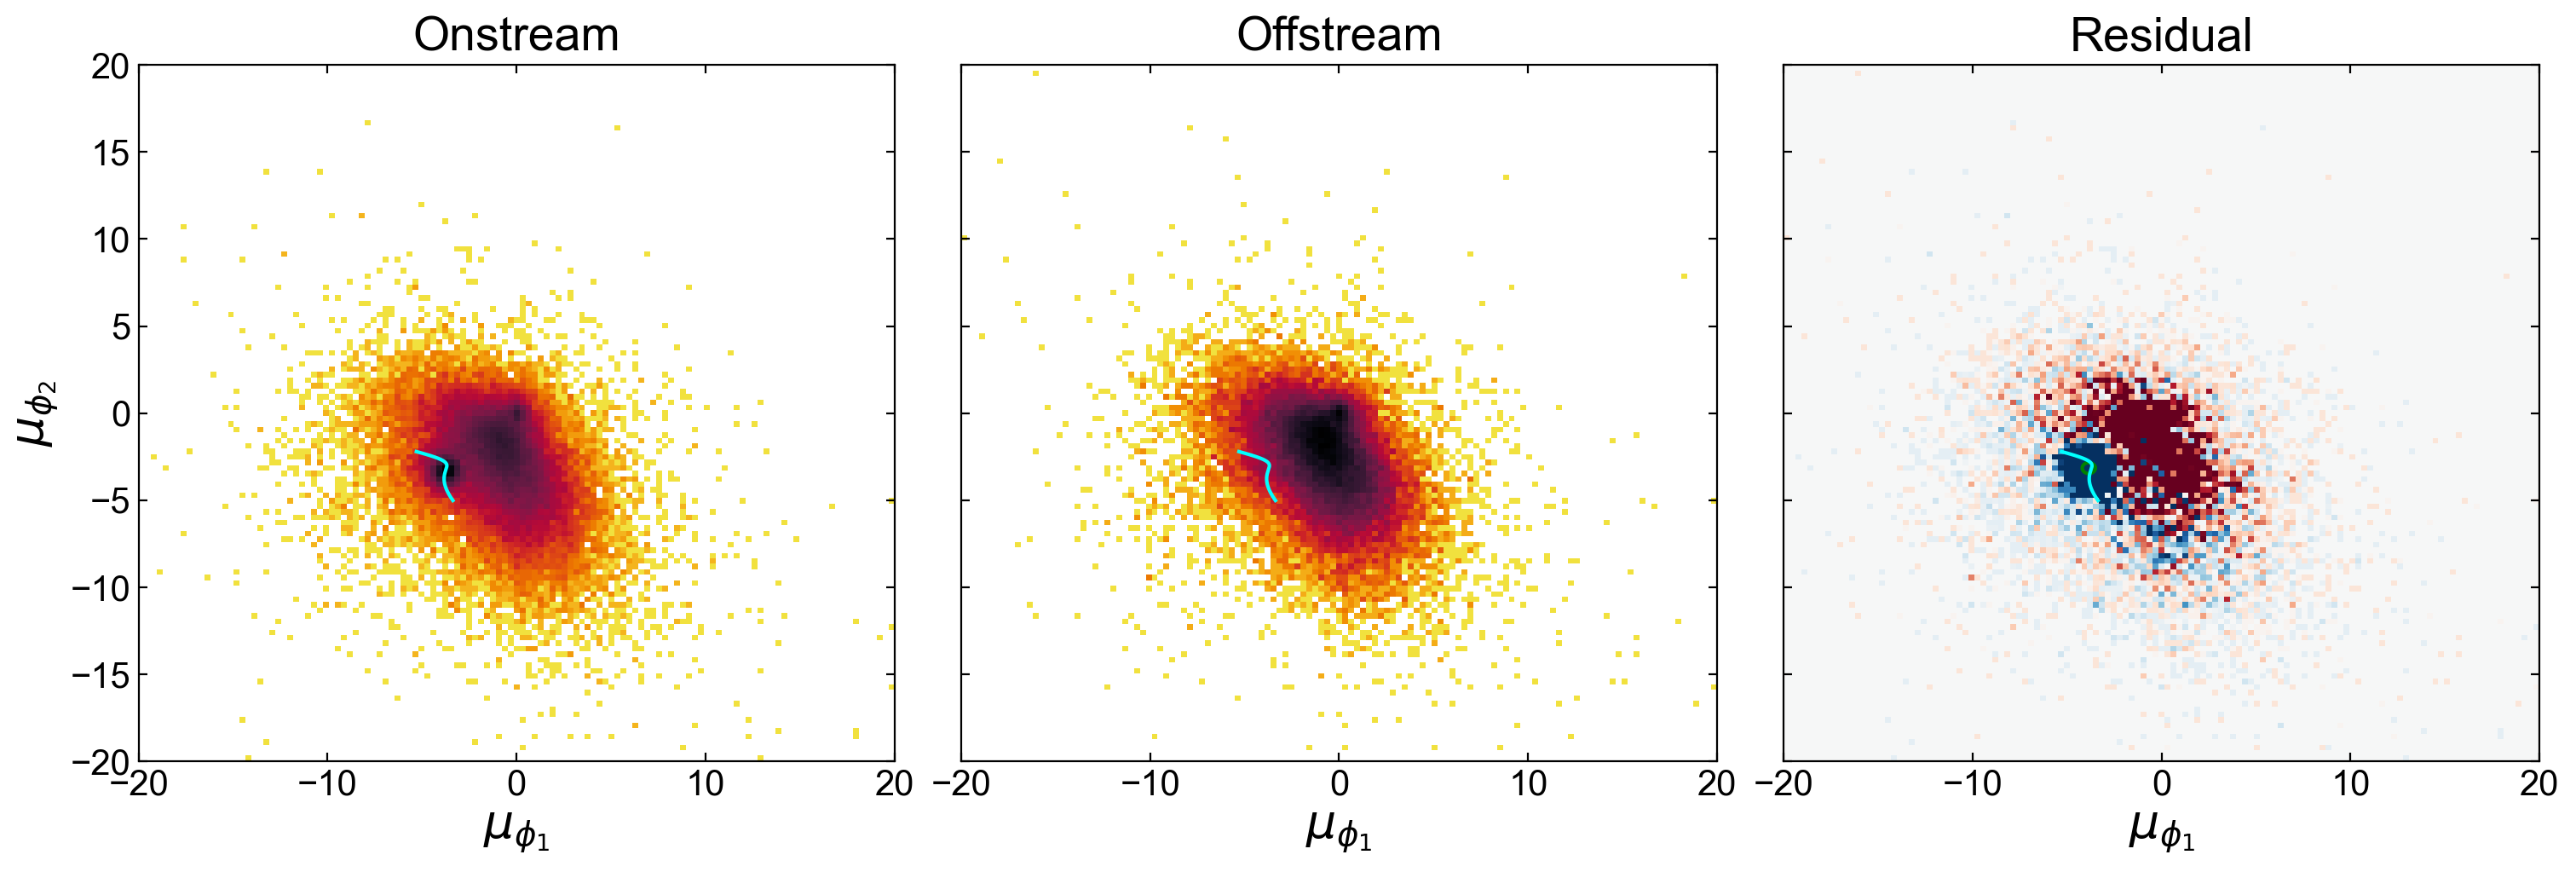

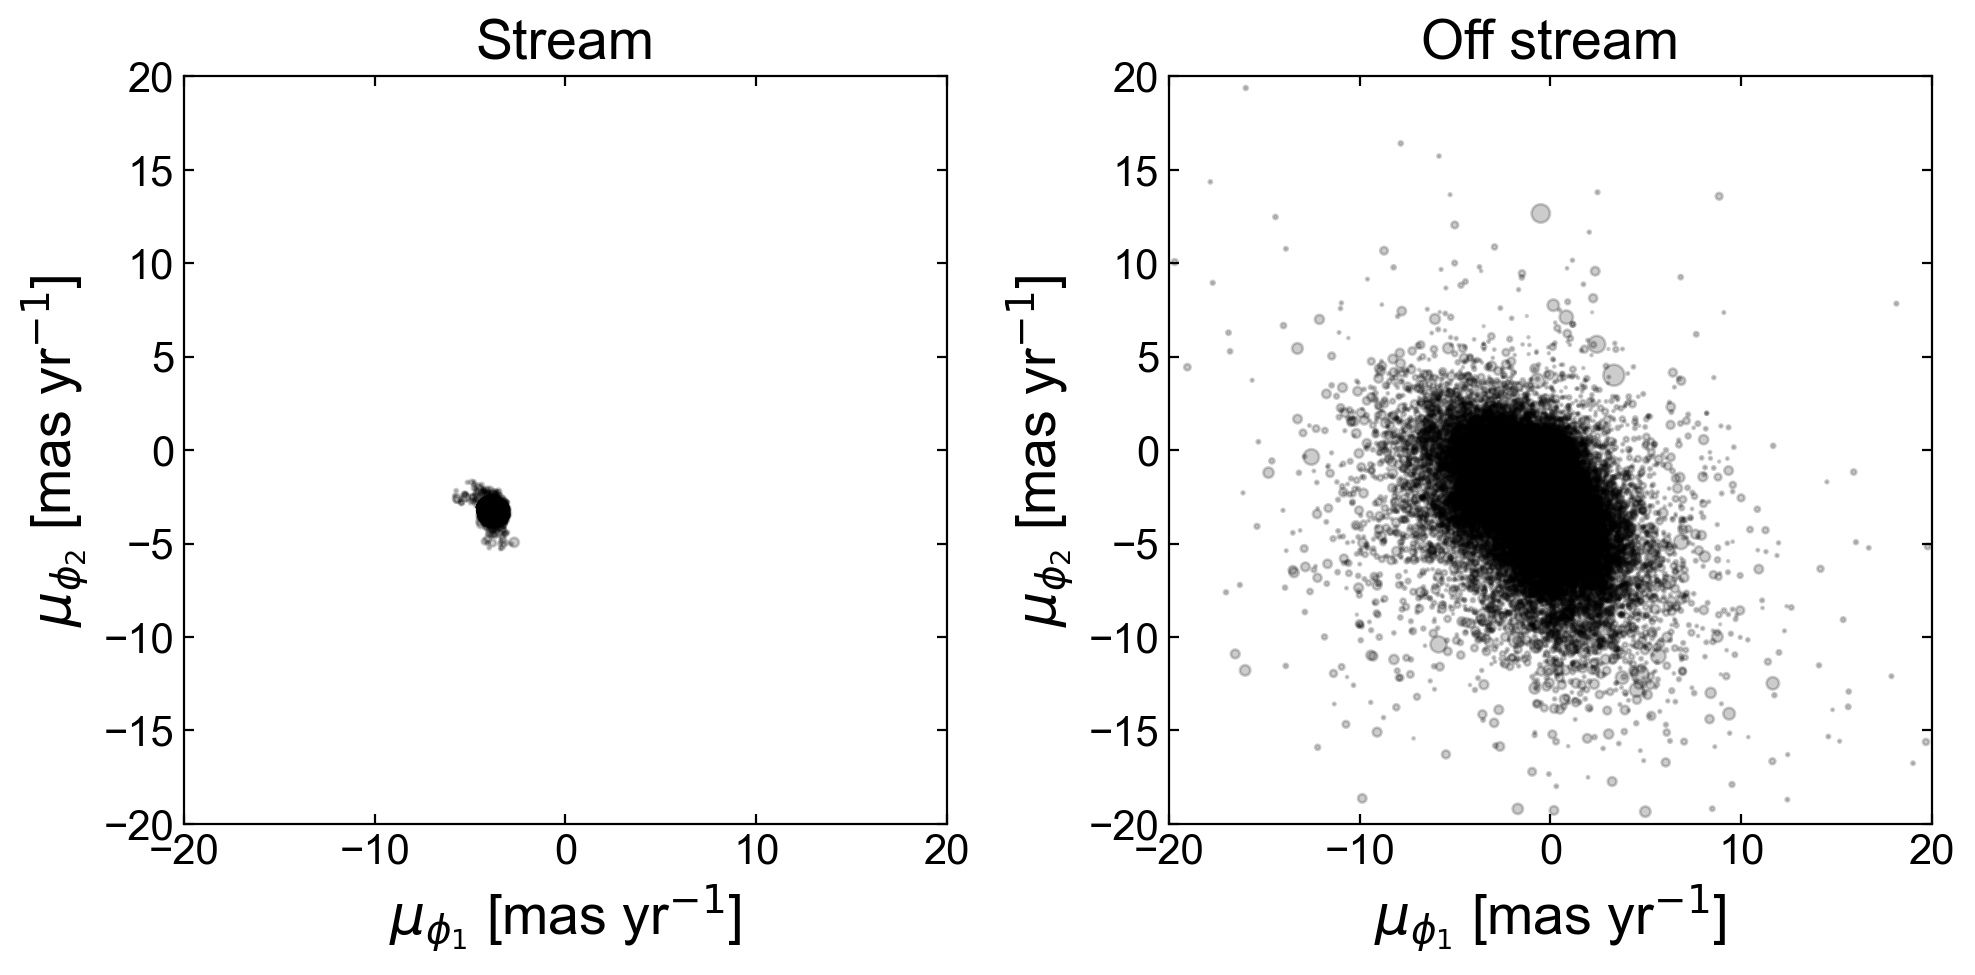

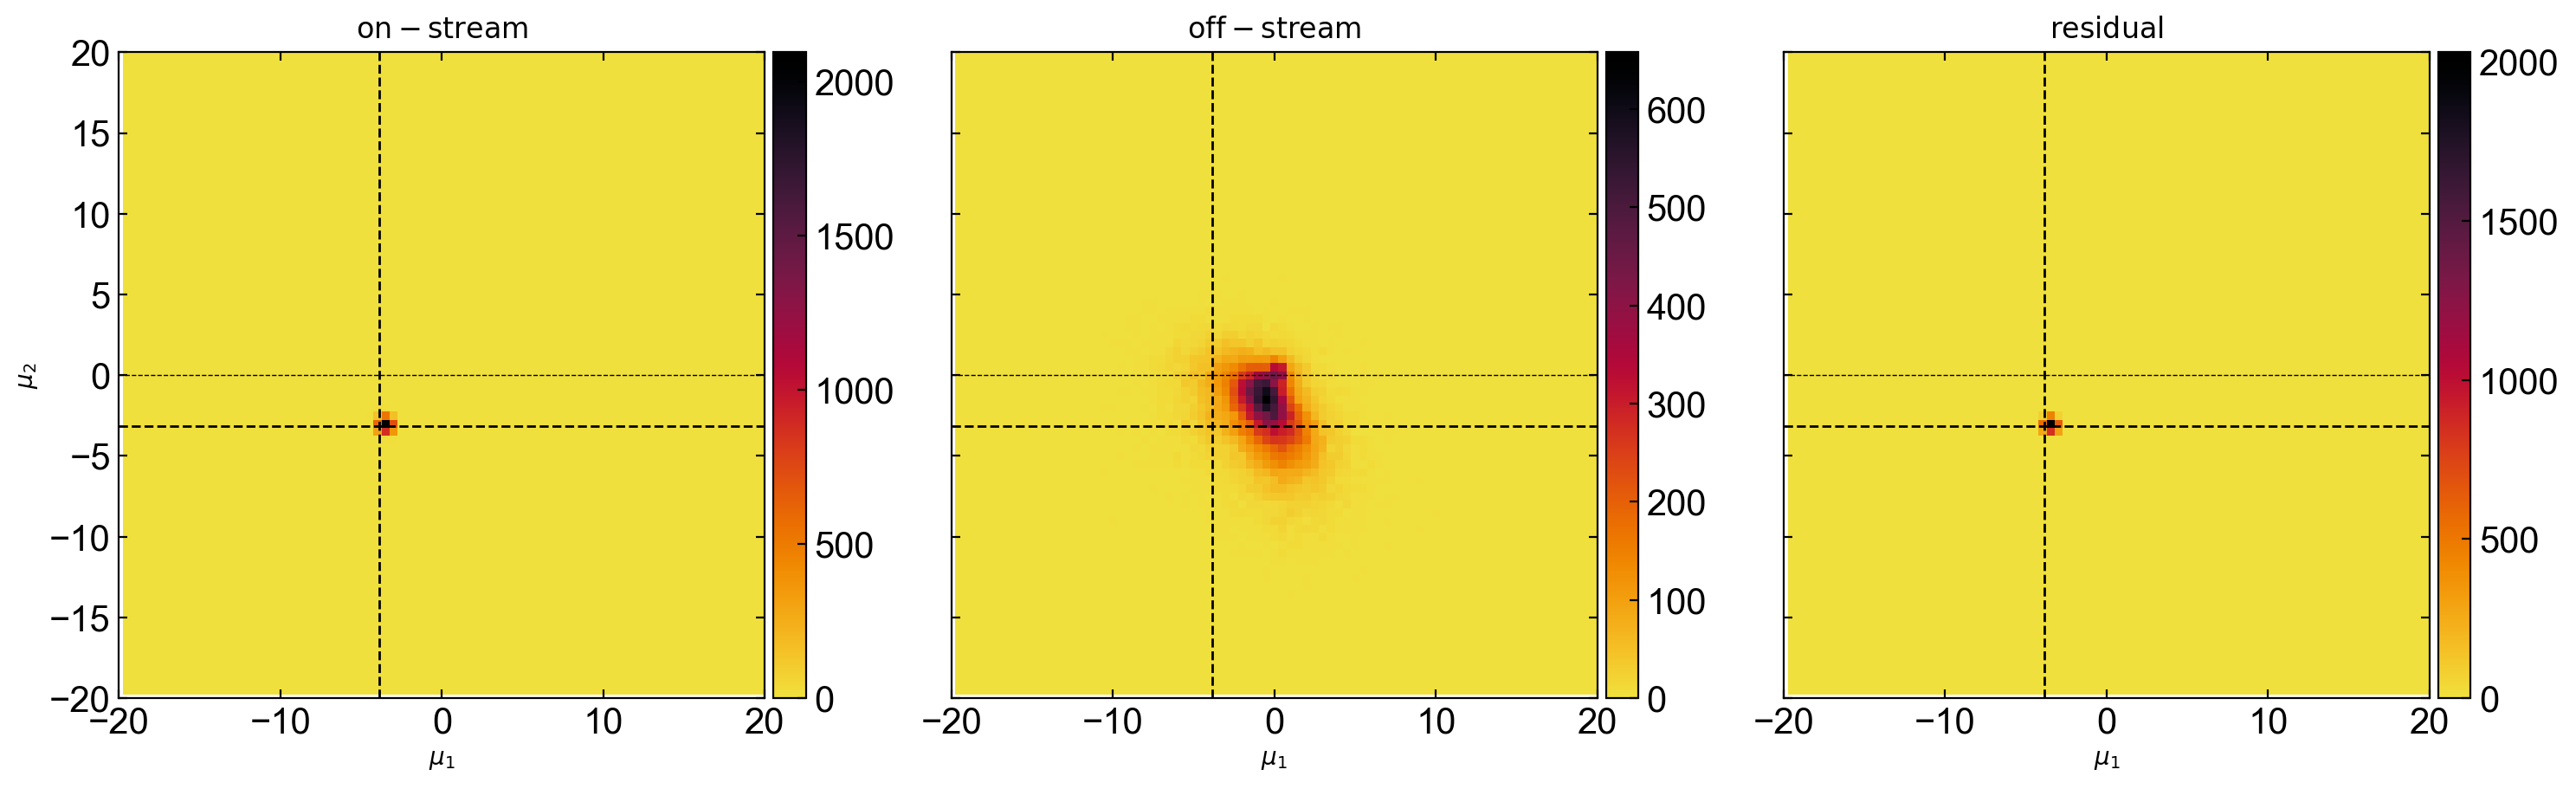

In [7]:
pmsel = ProperMotionSelection(cat, m92_dict, pprint,
                              n_dispersion_phi1=3, n_dispersion_phi2=3, cutoff=0.1, plot=True)

In [8]:
##### rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=1)

In [9]:
m92_cluster_mask = (np.abs(o.cat['phi2']) < 1) & (o.cat['phi1'] < -1.3) & (o.cat['phi1'] > -2.7)

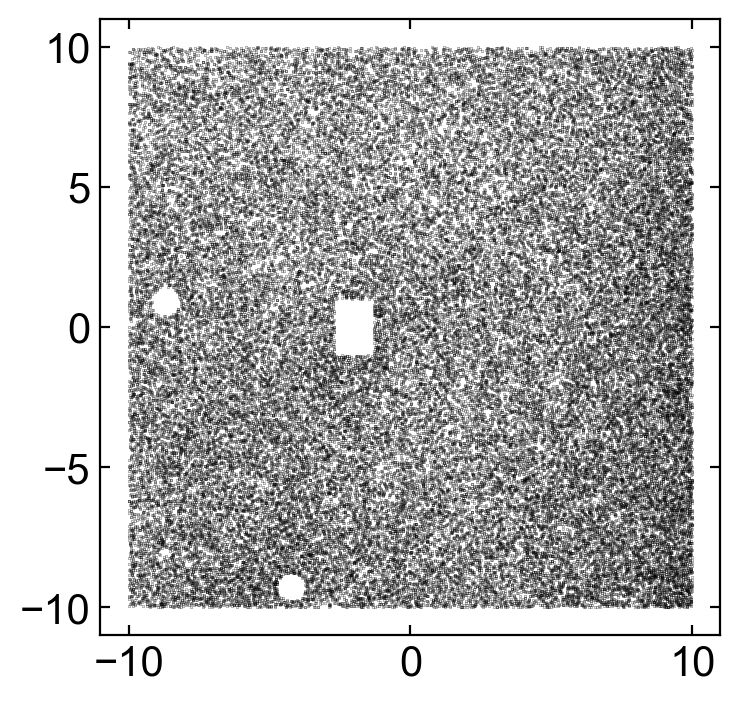

In [10]:
plt.figure(figsize=(4,4))
plt.scatter(o.cat[pmsel.rough_pm_mask & (iso_mask | hb_mask) & ~m92_cluster_mask]['phi1'],
            o.cat[pmsel.rough_pm_mask & (iso_mask | hb_mask) & ~m92_cluster_mask]['phi2'], s=0.01, c='k')
plt.show()

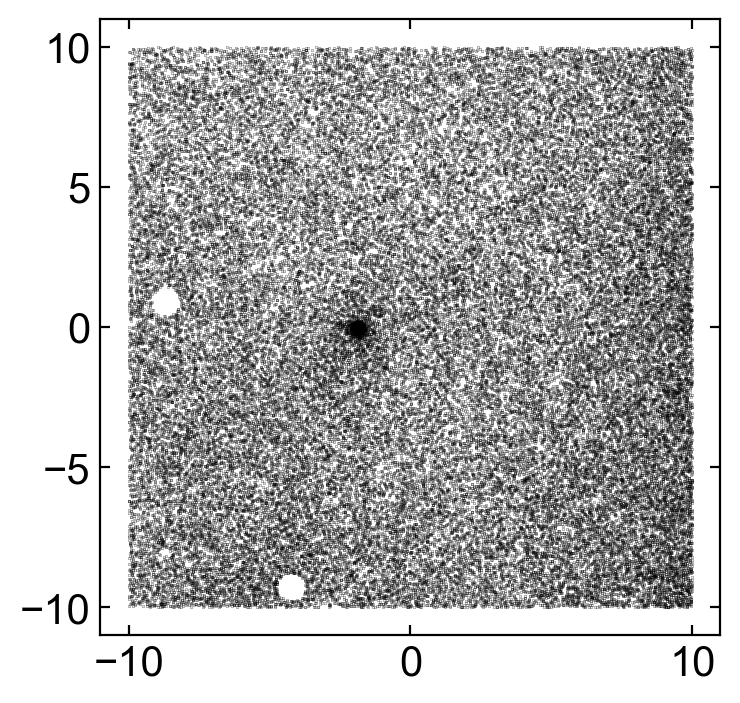

In [11]:
plt.figure(figsize=(4,4))
plt.scatter(o.cat[pmsel.rough_pm_mask & (iso_mask | hb_mask)]['phi1'],
            o.cat[pmsel.rough_pm_mask & (iso_mask | hb_mask)]['phi2'], s=0.01, c='k')
plt.show()

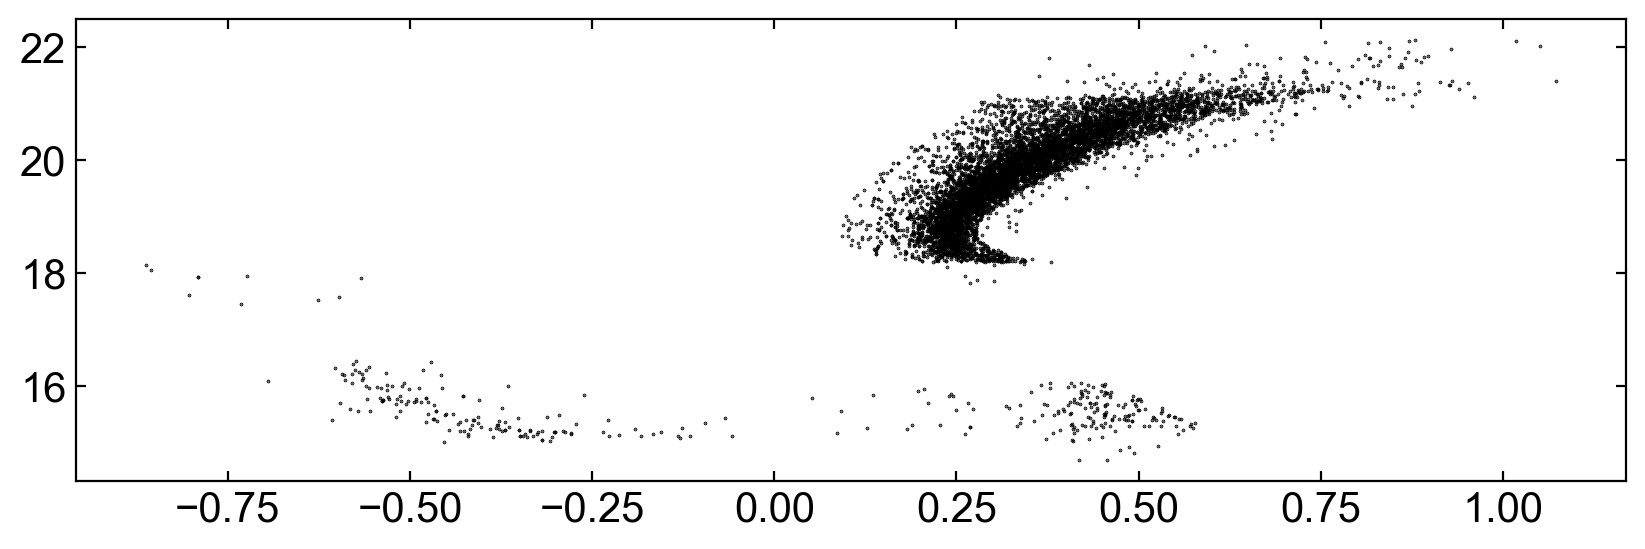

In [12]:
plt.figure(figsize=(10,3))
plt.scatter(o.cat[pmsel.pm12_mask & (iso_mask | hb_mask)]['g_0'] - o.cat[pmsel.pm12_mask & (iso_mask | hb_mask)]['i_0'],
            o.cat[pmsel.pm12_mask & (iso_mask | hb_mask)]['g_0'], s=0.1, c='k')
plt.show()

In [13]:
run_data_ = o.cat[pm_mask & (iso_mask | hb_mask) & ~m92_cluster_mask]
run_data = {k: np.array(run_data_[k], dtype="f8") for k in run_data_.colnames}


bkg_data_ = o.cat[pm_mask & (iso_mask | hb_mask) & ~o.on_skymask & ~m92_cluster_mask]
bkg_data = {k: np.array(bkg_data_[k], dtype="f8") for k in bkg_data_.colnames}


stream_data_ = o.cat[pmsel.pm12_mask & (iso_mask | hb_mask) & o.on_skymask  & ~m92_cluster_mask]
stream_data = {k: np.array(stream_data_[k], dtype="f8") for k in stream_data_.colnames}

In [14]:
len(stream_data_)

564

In [15]:
len(bkg_data_)

20856

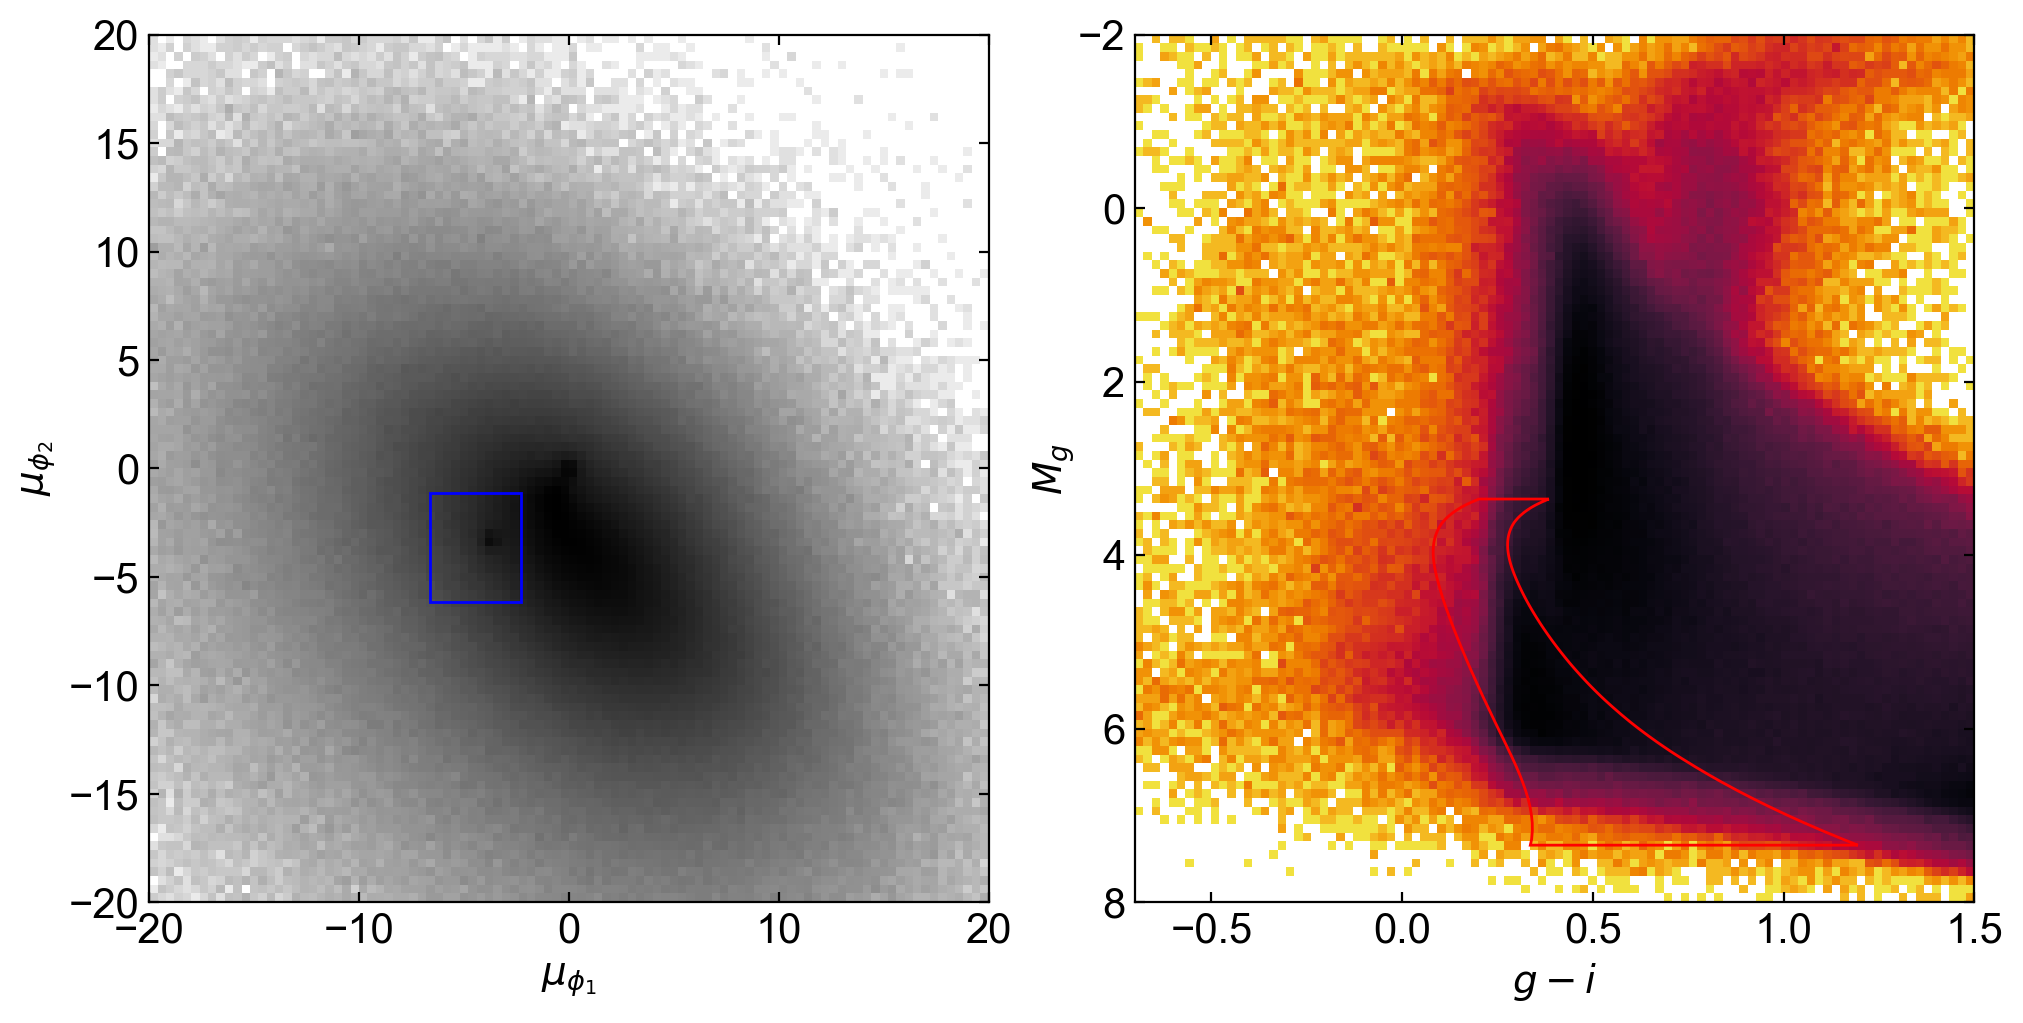

In [16]:
cmd_poly = o.pawprint.cmdprint.vertices - np.array([0,o.dist_mod])
cmd_patch = mpl.patches.Polygon(cmd_poly, edgecolor="red", facecolor="none")

pm_poly = o.pawprint.pmprint.vertices
pm_patch = mpl.patches.Polygon(pm_poly, edgecolor="blue", facecolor="none")

track = p.track.track.transform_to(p.track.stream_frame)
spline_dist = IUS(track.phi1.value, track.distance.value)
dist_mod_correct_all = (5 * np.log10(spline_dist(cat["phi1"]) * 1000) - 5) - o.dist_mod

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10,5), constrained_layout=True)
ax1.hist2d(o.cat['pm1'], o.cat['pm2'], cmap='gray_r', bins=100, range=[[-20,20],[-20,20]], 
           norm=mpl.colors.LogNorm(), rasterized=True)
ax1.add_patch(pm_patch)
ax1.set_xlim(-20,20)
ax1.set_ylim(-20,20)

ax2.hist2d(o.cat['g_0'] - o.cat['i_0'], o.cat['g_0'] - dist_mod_correct_all  - o.dist_mod, 
           bins=100, range=[[-0.7,1.5],[-2,8]], norm=mpl.colors.LogNorm(), rasterized=True)
ax2.add_patch(cmd_patch)
ax2.set_xlim(-0.7, 1.5)
ax2.set_ylim(8, -2)

ax1.set_xlabel(r'$\mu_{\phi_1}$', fontsize=14)
ax1.set_ylabel(r'$\mu_{\phi_2}$', fontsize=14)

ax2.set_xlabel(r'$g-i$', fontsize=14)
ax2.set_ylabel(r'$M_g$', fontsize=14, labelpad=0.1)
# plt.savefig('../../paper_figures/m92_cuts.pdf')
plt.show()

# Background

In [17]:
BkgModel = make_bkg_model(BackgroundModel, p, cat, knot_sep=5, phi2_bkg=True)

In [18]:
bkg_init_p = {
    "ln_N": np.log(len(bkg_data['phi1'])),
    "phi1": {'zs': np.zeros(BkgModel.phi1_locs.shape[0]-1)},
    "phi2": {
        'mean':np.full_like(BkgModel.phi2_knots, -5),
        'ln_std': np.full_like(BkgModel.phi2_knots, 3),
    },
    "pm1": {
        "w": np.full_like(BkgModel.pm1_knots, 0.5),
        "mean1": np.full_like(BkgModel.pm1_knots, 3),
        "ln_std1": np.full_like(BkgModel.pm1_knots, 1),
        "mean2": np.full_like(BkgModel.pm1_knots, 5),
        "ln_std2": np.full_like(BkgModel.pm1_knots, 2)
    },
    "pm2": {
        "w": np.full_like(BkgModel.pm2_knots, 0.5),
        "mean1": np.full_like(BkgModel.pm2_knots, 0),
        "ln_std1": np.full_like(BkgModel.pm2_knots, 1),
        "mean2": np.full_like(BkgModel.pm2_knots, 1),
        "ln_std2": np.full_like(BkgModel.pm2_knots, 2)
    },
}

background_init = BkgModel(bkg_init_p)

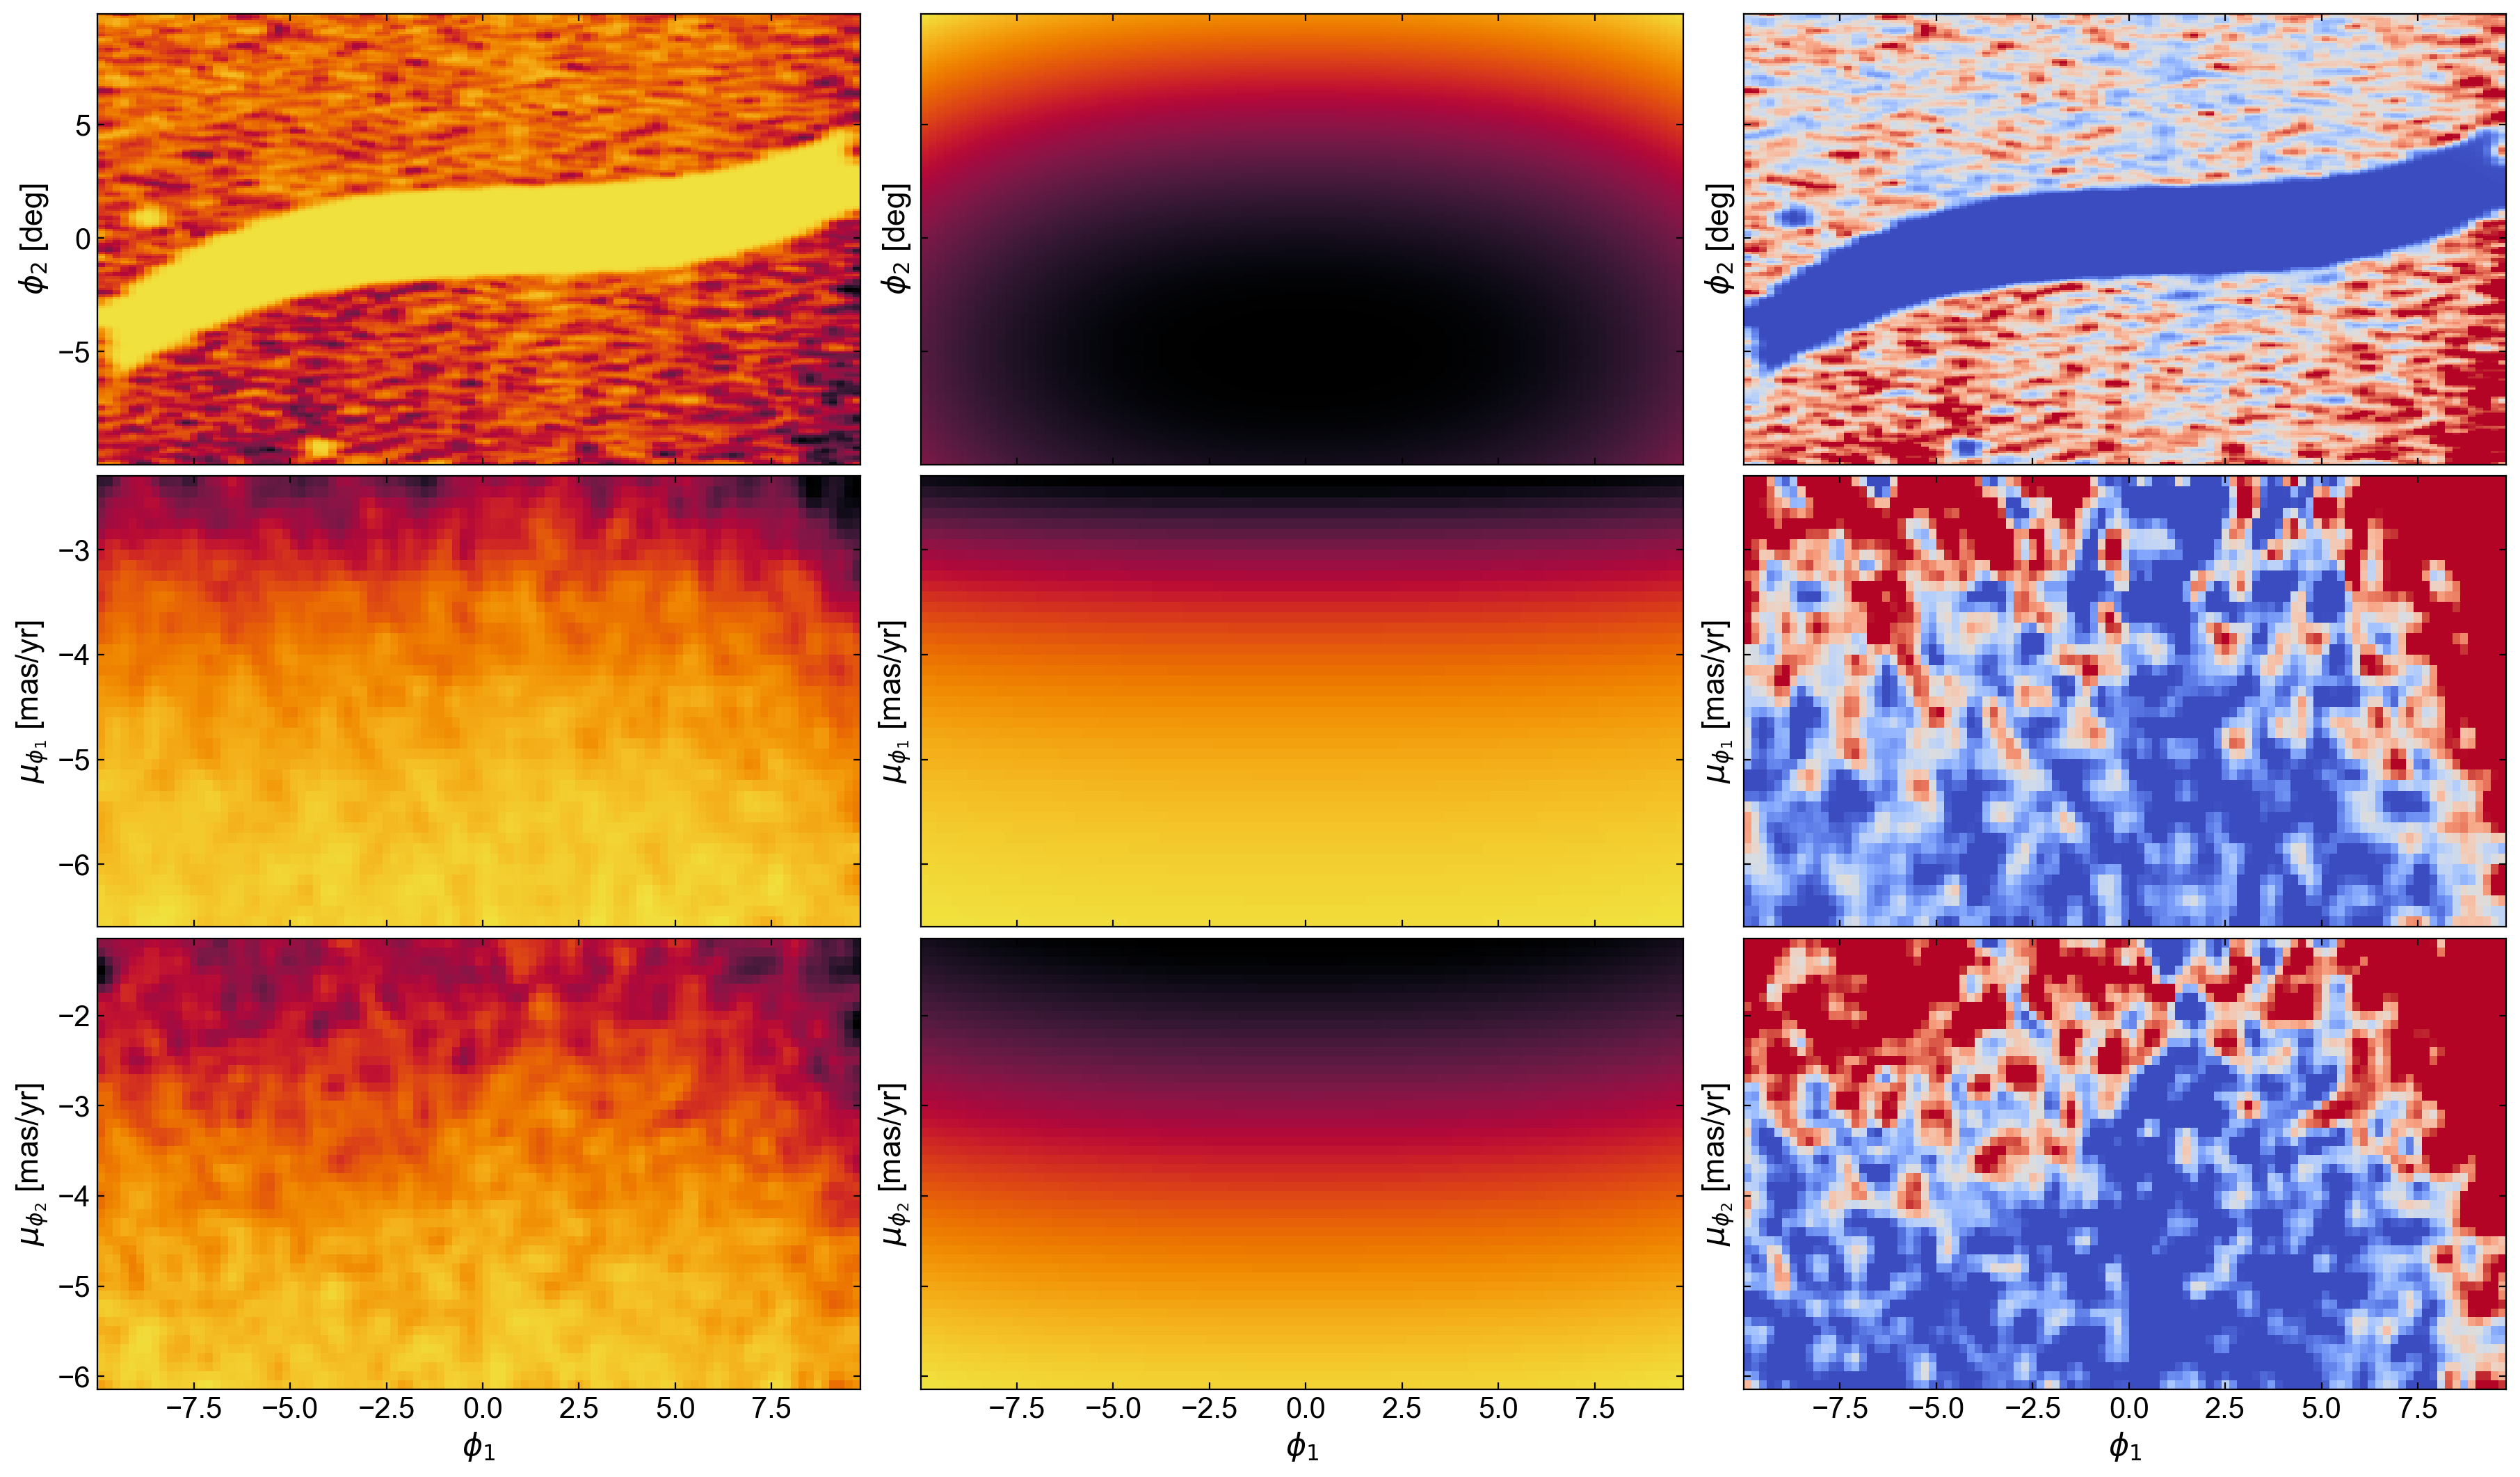

In [19]:
fig, axes = plt.subplots(
    len(background_init.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_init.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=background_init.default_grids,
    axes=axes[:, 0],
    # coord_names=GD1BackgroundModel.coord_names,
)
background_init.plot_model_projections(axes=axes[:, 1])
background_init.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

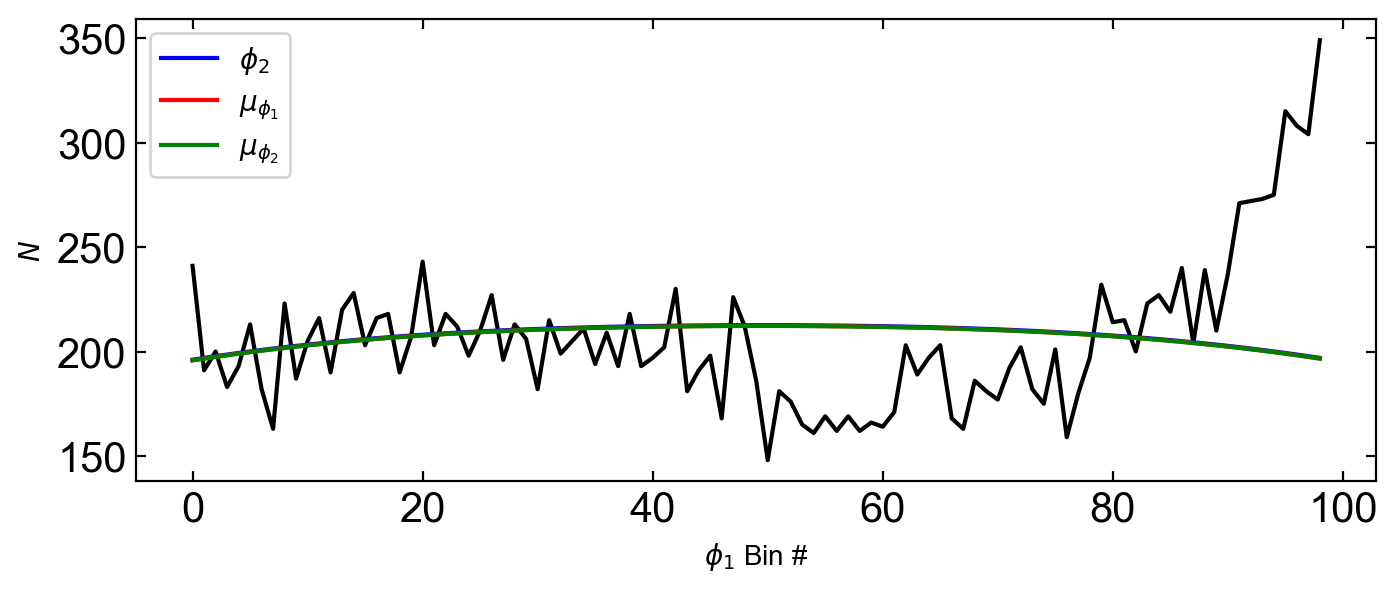

In [20]:
H_data1, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["phi2"],
    bins=(background_init.default_grids["phi1"], background_init.default_grids['phi2'])
)

grids, ln_ns = background_init.evaluate_on_2d_grids()

fig, ax1 = plt.subplots(1,1,figsize=(8, 3))
ax1.plot(H_data1.sum(axis=1), c='k')
ax1.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b', label=r'$\phi_2$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='r', label=r'$\mu_{\phi_1}$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='g', label=r'$\mu_{\phi_2}$')
ax1.set_xlabel(r'$\phi_1$ Bin #')
ax1.set_ylabel(r'$N$')
ax1.legend()
plt.show()

In [21]:
def optimize(cls, data, init_params, jaxopt_kwargs=None, use_bounds=True, **kwargs):
    """
    A wrapper around numpyro_ext.optim utilities, which enable jaxopt optimization
    for numpyro models.
    """
    import jaxopt

    if jaxopt_kwargs is None:
        jaxopt_kwargs = {}
    jaxopt_kwargs.setdefault("maxiter", 1024)  # TODO: TOTALLY ARBITRARY

    optimize_kwargs = kwargs
    #jaxopt_kwargs.setdefault("method", "L-BFGS-B")
    optimize_kwargs["bounds"] = cls._get_jaxopt_bounds()
    optimize_kwargs["bounds"] = (
        cls._normalize_variable_keys(optimize_kwargs["bounds"][0]),
        cls._normalize_variable_keys(optimize_kwargs["bounds"][1]),
    )
    Optimizer = jaxopt.LBFGSB

    optimizer = Optimizer(**jaxopt_kwargs, fun=cls._objective)
    opt_res = optimizer.run(
        init_params=cls._normalize_variable_keys(init_params),
        data=cls._normalize_variable_keys(data),
        **optimize_kwargs,
    )
    return cls._expand_variable_keys(opt_res.params), opt_res.state

In [22]:
bkg_opt_pars, bkg_info = background_init.optimize(
    data=bkg_data,
    init_params=bkg_init_p,
    use_bounds=True,
    jaxopt_kwargs=dict(maxiter=4096),
)

background_opt = BkgModel(bkg_opt_pars)
bkg_info

INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.028972798144129487 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.028972798144129487 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.5263193749756192  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.7894790624634288  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease 

LbfgsbState(iter_num=Array(43, dtype=int64, weak_type=True), value=Array(-0.28352153, dtype=float64), grad={'ln_N': Array(0.00090663, dtype=float64), 'phi1': {'zs': Array([ 1.59643159e-04, -7.20007711e-05, -1.16610625e-05, -4.27294512e-07,
        2.60340927e-06,  1.03908151e-05], dtype=float64)}, 'phi2': {'ln_std': Array([-1.14819849e-05,  1.51978833e-04, -5.15299483e-05,  5.83598450e-04,
        8.80681425e-04], dtype=float64), 'mean': Array([-3.88291457e-06,  5.40367471e-05,  2.49369855e-05,  5.88707142e-04,
        2.93206919e-04], dtype=float64)}, 'pm1': {'ln_std1': Array([-1.76430015e-04, -4.14438597e-05,  2.48616473e-04,  2.98754833e-04,
        2.54139437e-05], dtype=float64), 'ln_std2': Array([ 7.57493148e-05,  1.09516011e-04, -2.30057632e-04, -5.23472770e-04,
        1.15733689e-05], dtype=float64), 'mean1': Array([ 1.71875814e-05, -5.94121905e-06, -2.98047719e-05, -7.38661957e-05,
       -1.27071189e-05], dtype=float64), 'mean2': Array([-4.34604770e-06, -5.79682314e-06,  1.4

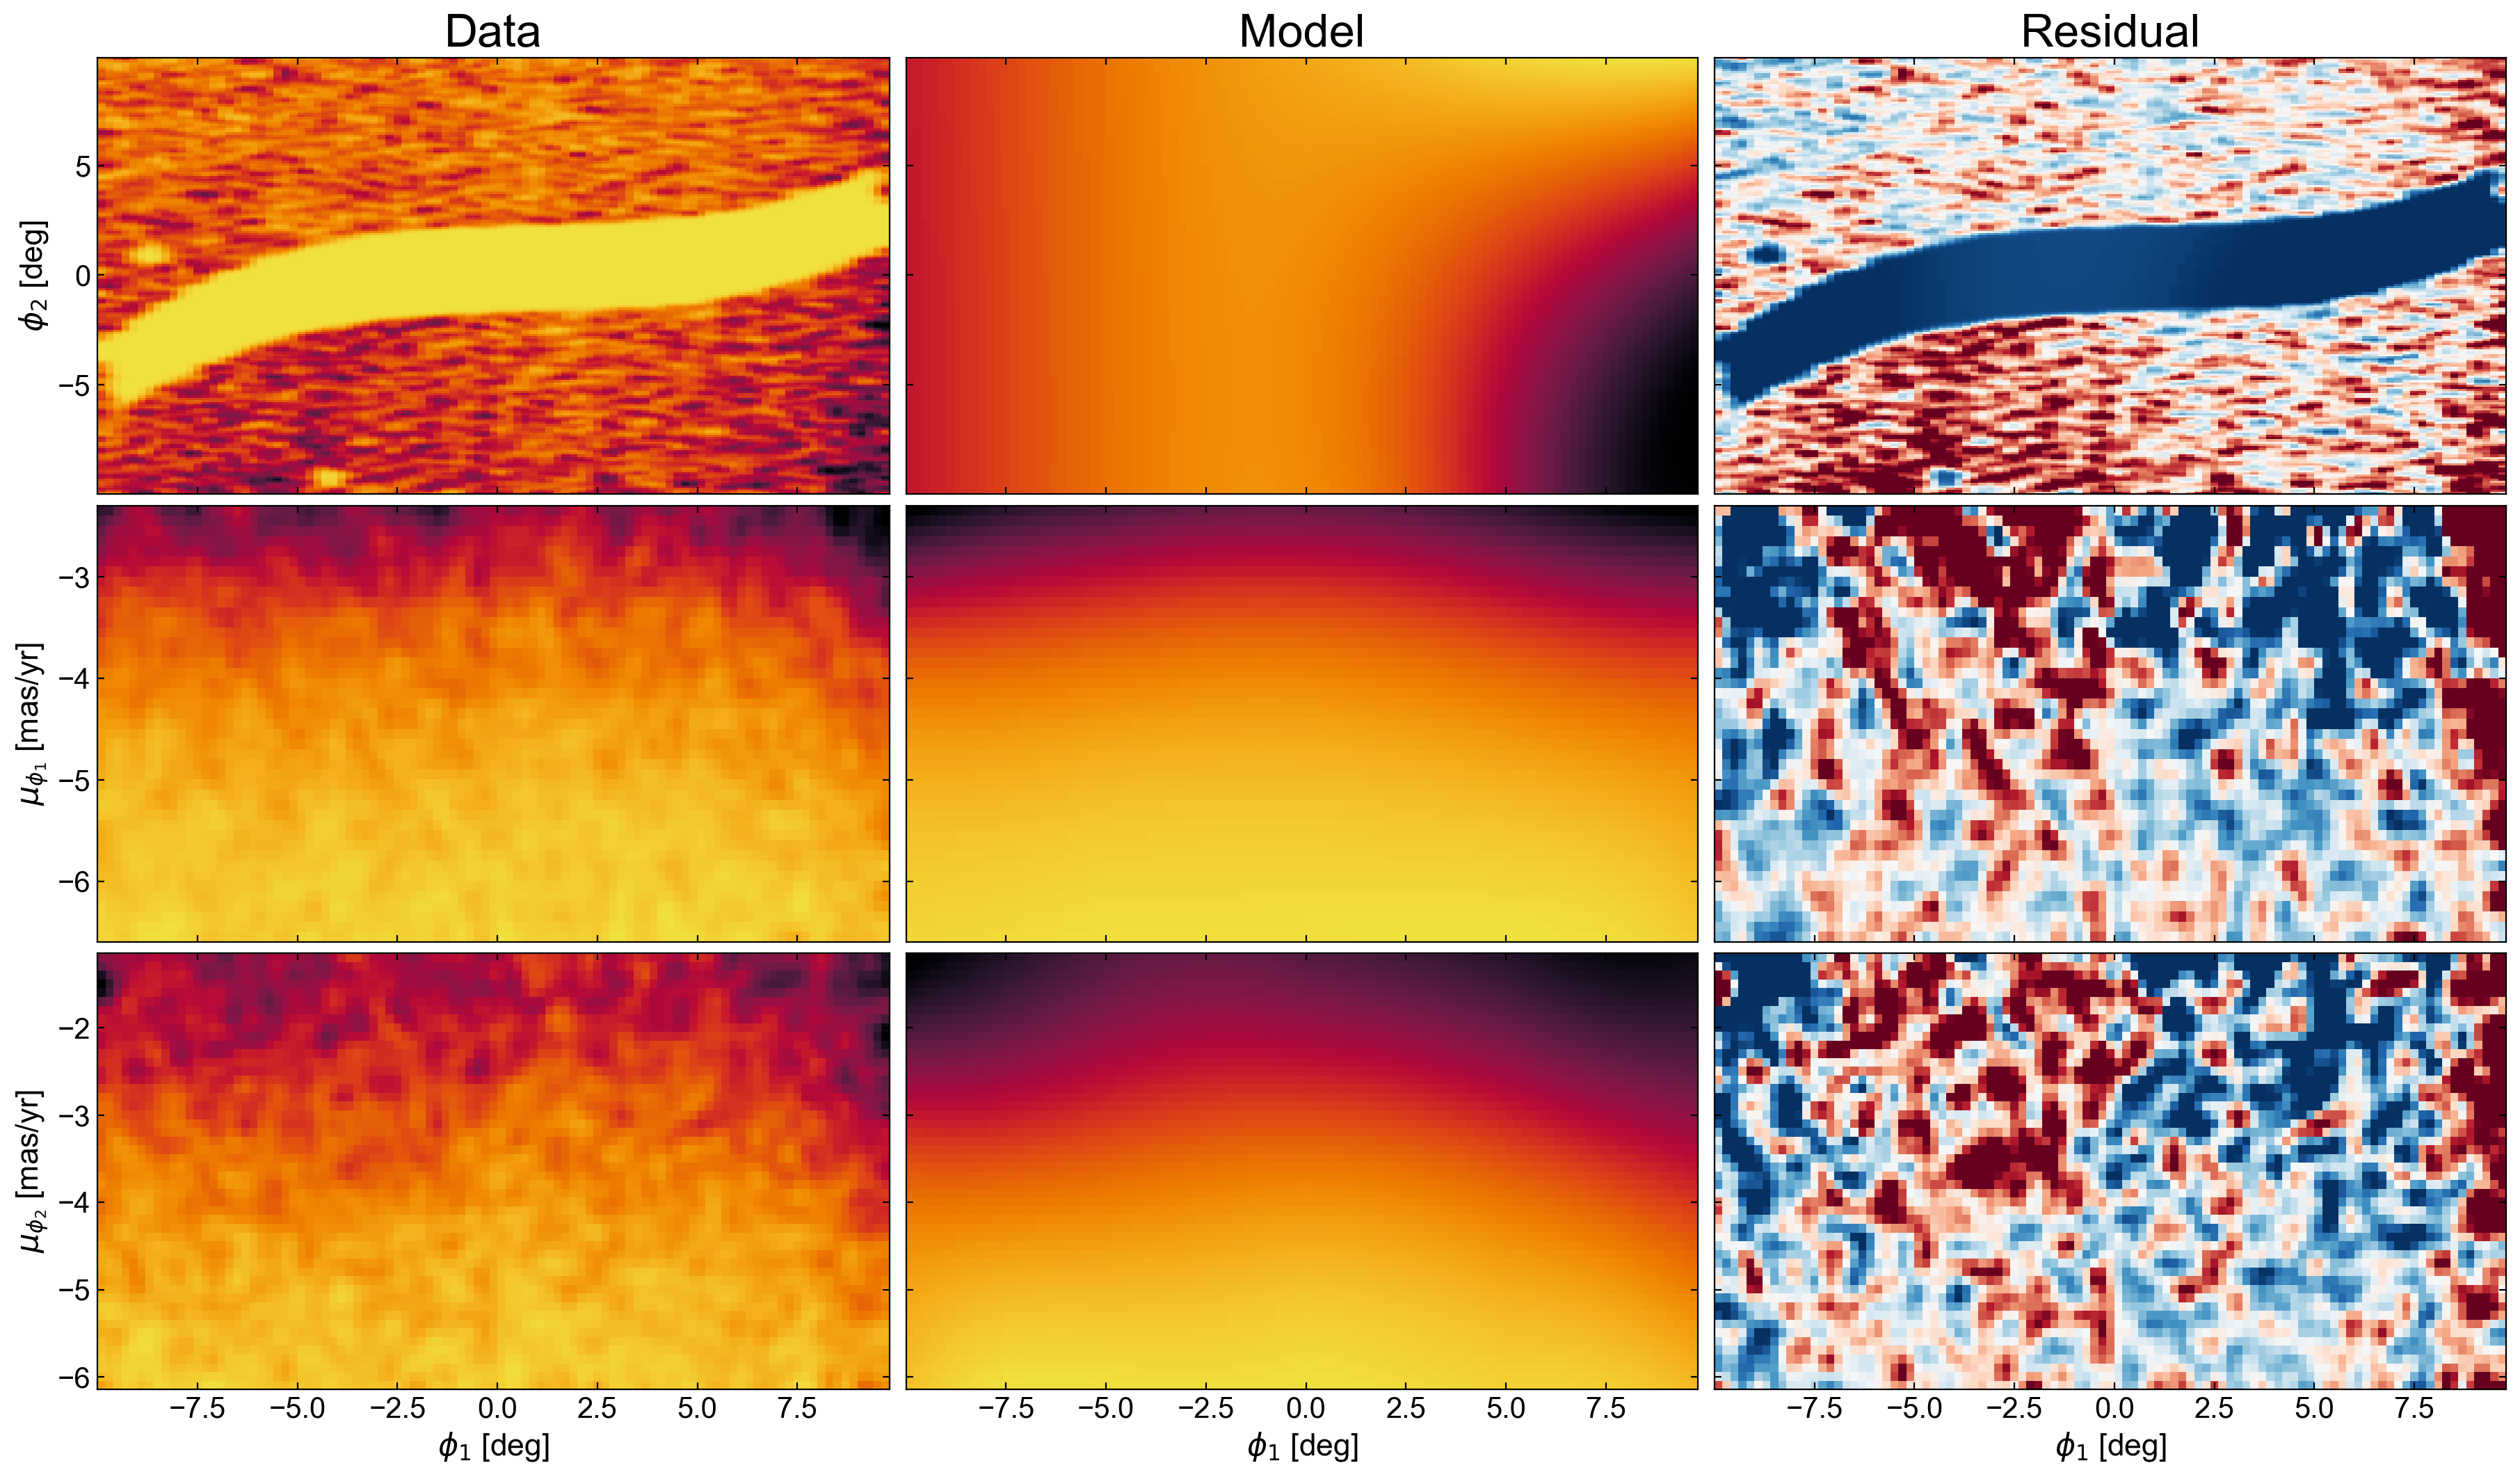

In [23]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=BackgroundModel.default_grids,
    axes=axes[:, 0],
    pcolormesh_kwargs=dict(rasterized=True)
    # coord_names=GD1BackgroundModel.coord_names,
)
background_opt.plot_model_projections(axes=axes[:, 1], label=False,
                                     pcolormesh_kwargs=dict(rasterized=True))
background_opt.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], label=False, 
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu', rasterized=True)
)
axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)
plt.show()

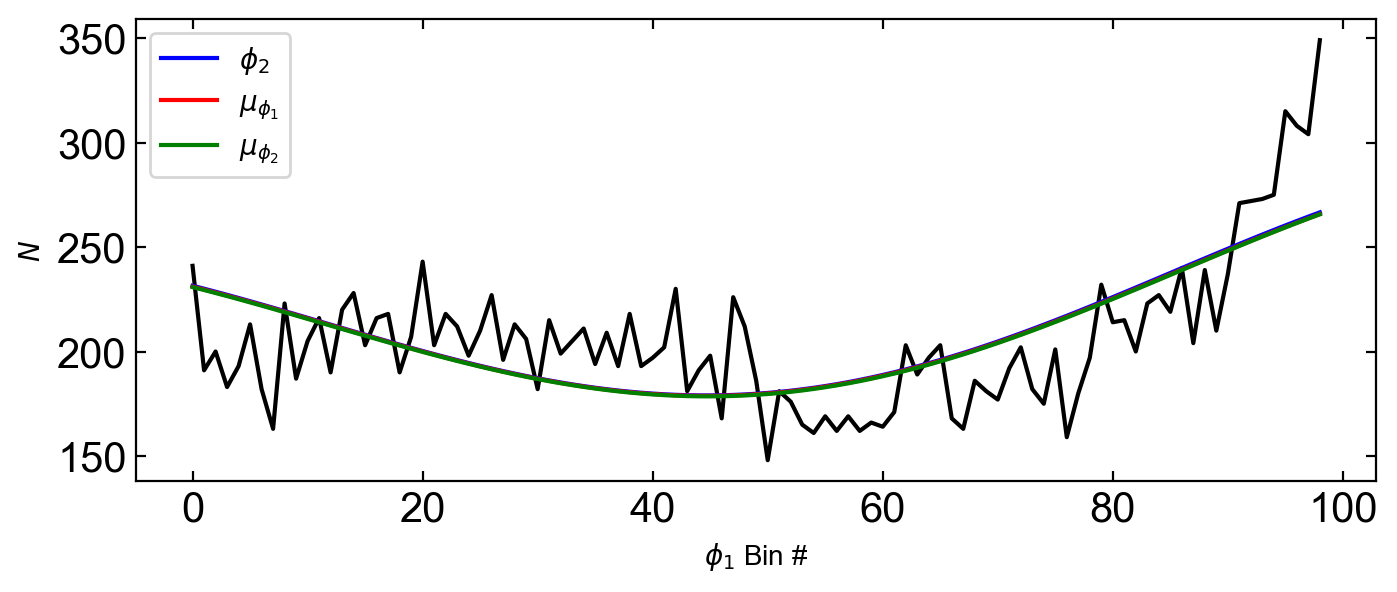

In [24]:
H_data1, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["phi2"],
    bins=(background_opt.default_grids["phi1"], background_opt.default_grids['phi2'])
)

grids, ln_ns = background_opt.evaluate_on_2d_grids()

fig, ax1 = plt.subplots(1,1,figsize=(8, 3))
ax1.plot(H_data1.sum(axis=1), c='k')
ax1.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b', label=r'$\phi_2$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='r', label=r'$\mu_{\phi_1}$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='g', label=r'$\mu_{\phi_2}$')
ax1.set_xlabel(r'$\phi_1$ Bin #')
ax1.set_ylabel(r'$N$')
ax1.legend()
plt.show()

# Stream

In [25]:
StrModel = make_stream_model(StreamDensModel, p, cat, knot_sep=5)

In [26]:
# TODO: replace this with galstreams initialization
from scipy.stats import binned_statistic
from scipy.interpolate import InterpolatedUnivariateSpline

_phi2_stat = binned_statistic(stream_data["phi1"], stream_data["phi2"], bins=np.linspace(phi1_lim[0], phi1_lim[1], 21))
_phi2_interp = IUS(
    0.5 * (_phi2_stat.bin_edges[:-1] + _phi2_stat.bin_edges[1:]), _phi2_stat.statistic, ext=0, k=1
)

_pm1_stat = binned_statistic(stream_data["phi1"], stream_data["pm1"], bins=np.linspace(phi1_lim[0], phi1_lim[1], 32))
_pm1_interp = IUS(
    0.5 * (_pm1_stat.bin_edges[:-1] + _pm1_stat.bin_edges[1:]), _pm1_stat.statistic, ext=0, k=1
)

_pm2_stat = binned_statistic(stream_data["phi1"], stream_data["pm2"], bins=np.linspace(phi1_lim[0], phi1_lim[1], 32))
_pm2_interp = IUS(
    0.5 * (_pm2_stat.bin_edges[:-1] + _pm2_stat.bin_edges[1:]), _pm2_stat.statistic, ext=0, k=1
)

In [27]:
_pm1_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi1_cosphi2,
                                         ext=3)
_pm2_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi2,
                                         ext=3)

In [28]:
stream_init_p = {
    "ln_N": np.log(len(stream_data['phi1'])),
    "phi1": {
        "zs": np.zeros(StreamDensModel.phi1_locs.shape[0]-1)
    },
    "phi2": {
        "mean": _phi2_interp(StreamDensModel.phi2_knots),
        "ln_std": np.full_like(StreamDensModel.phi2_knots, np.log(inputs[stream]['width']/2))
    },
    "pm1": {
        "mean": _pm1_interp(StreamDensModel.pm1_knots),
        "ln_std": np.full_like(StreamDensModel.pm1_knots, -0.5)
    },
    "pm2": {
        "mean": _pm2_interp(StreamDensModel.pm2_knots),
        "ln_std": np.full_like(StreamDensModel.pm2_knots, -0.5)
    }
}

stream_init = StrModel(stream_init_p)

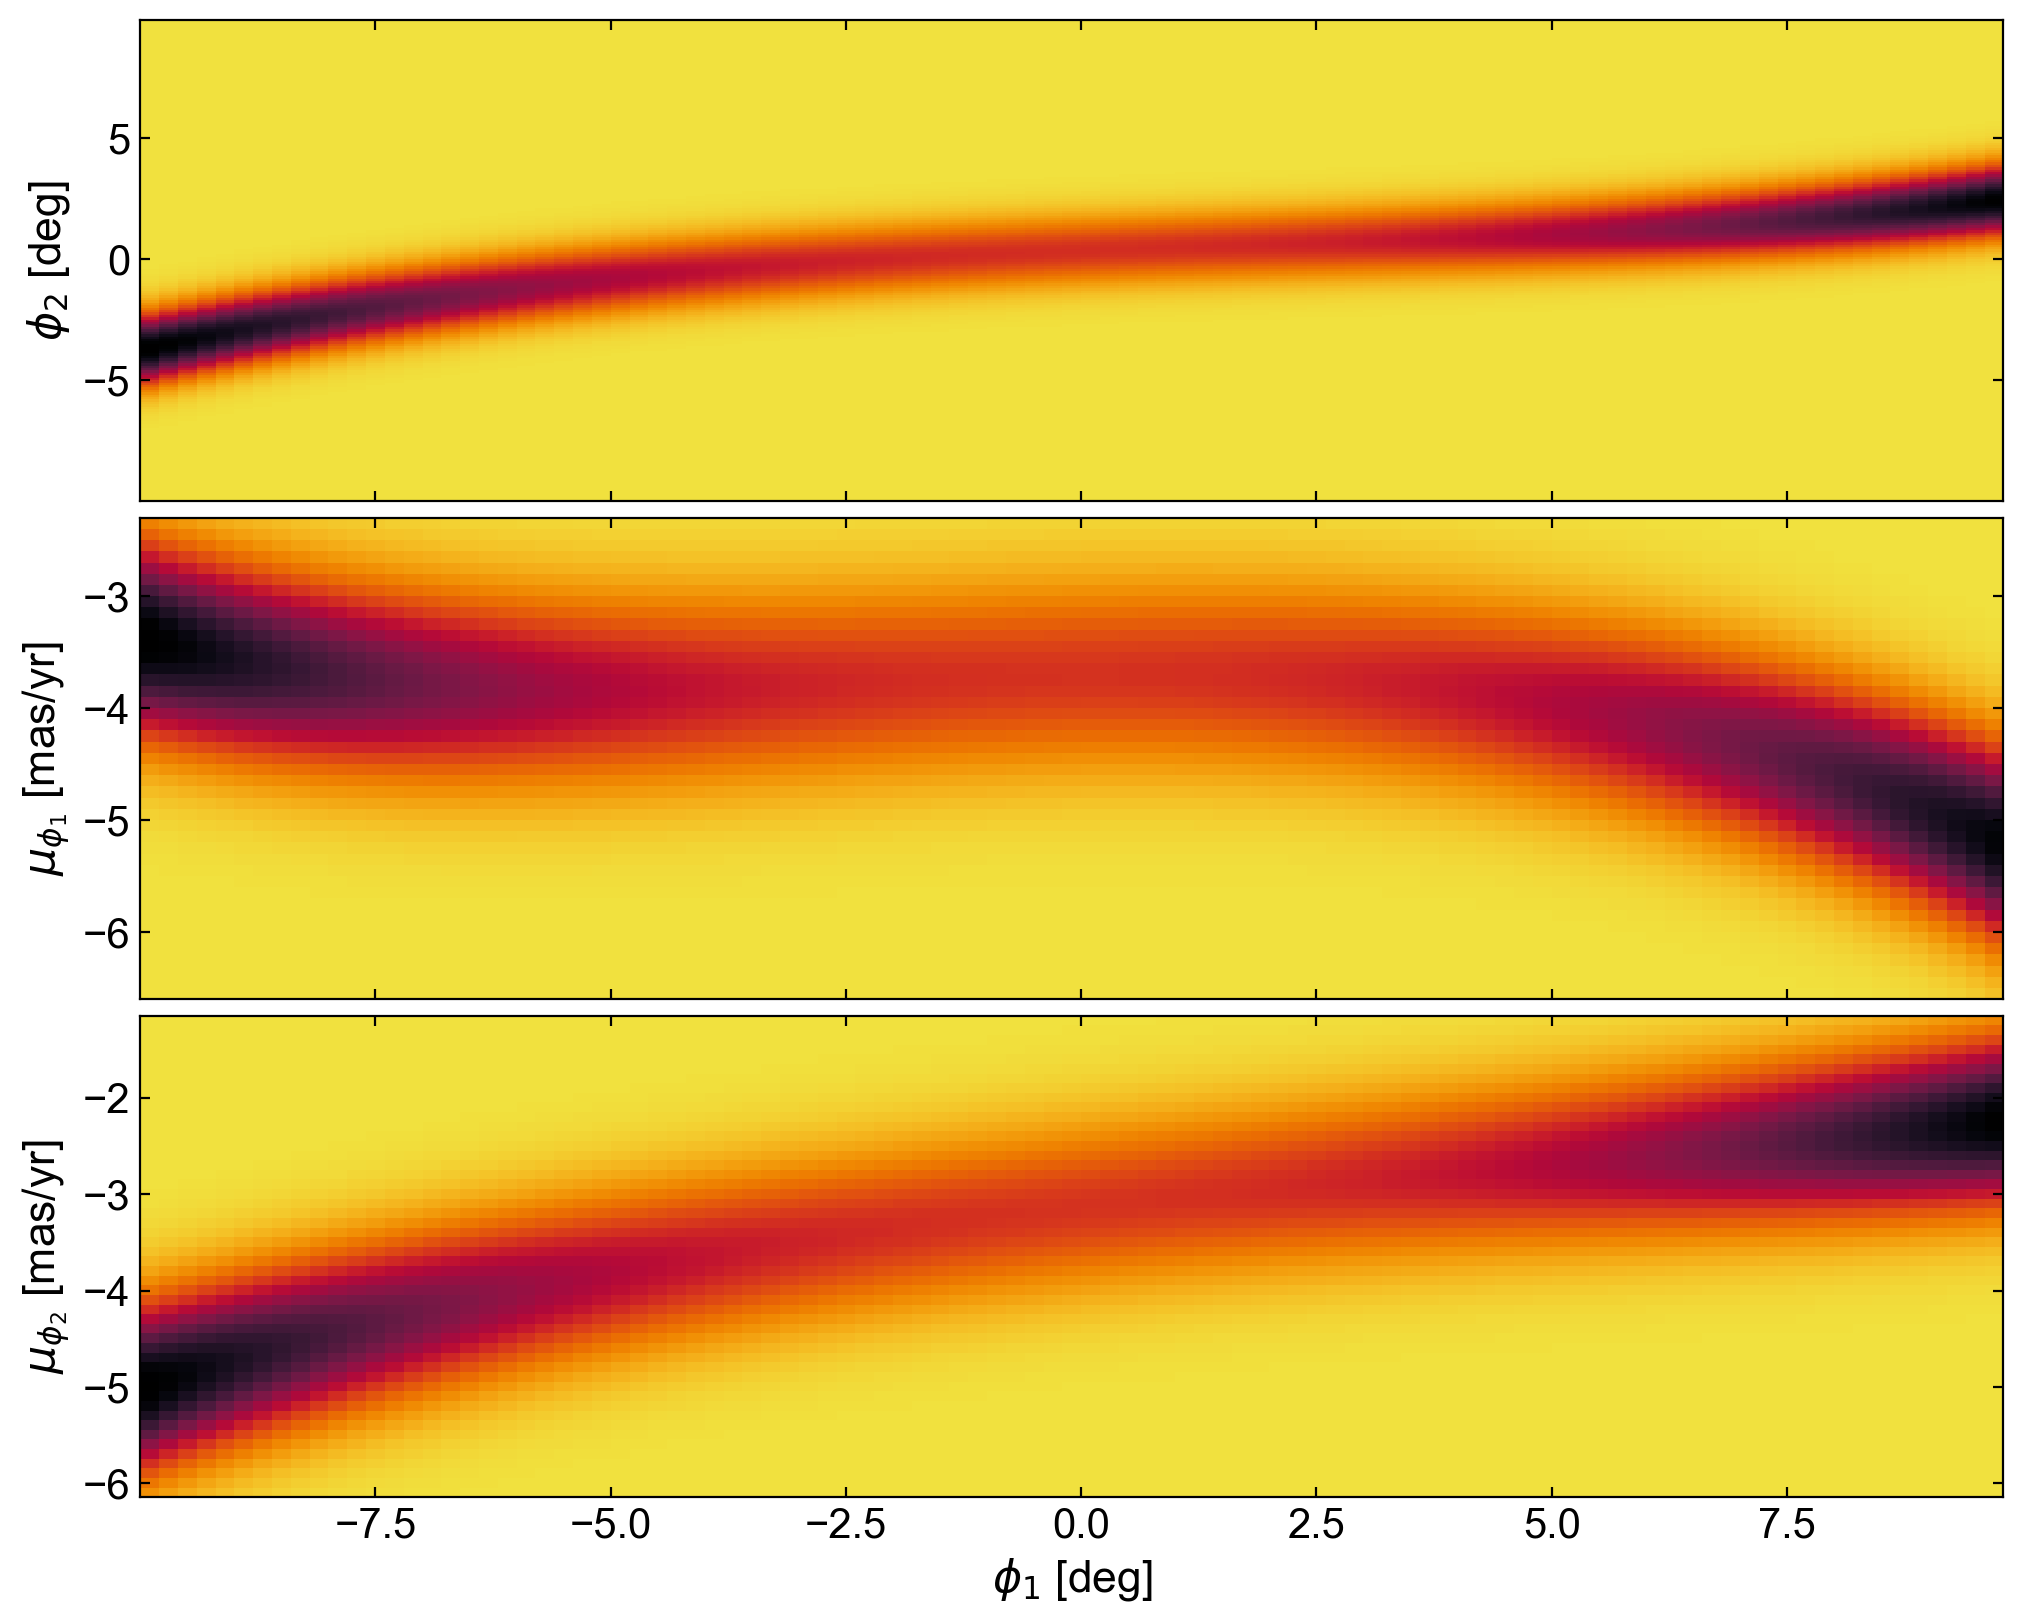

In [29]:
_ = stream_init.plot_model_projections()

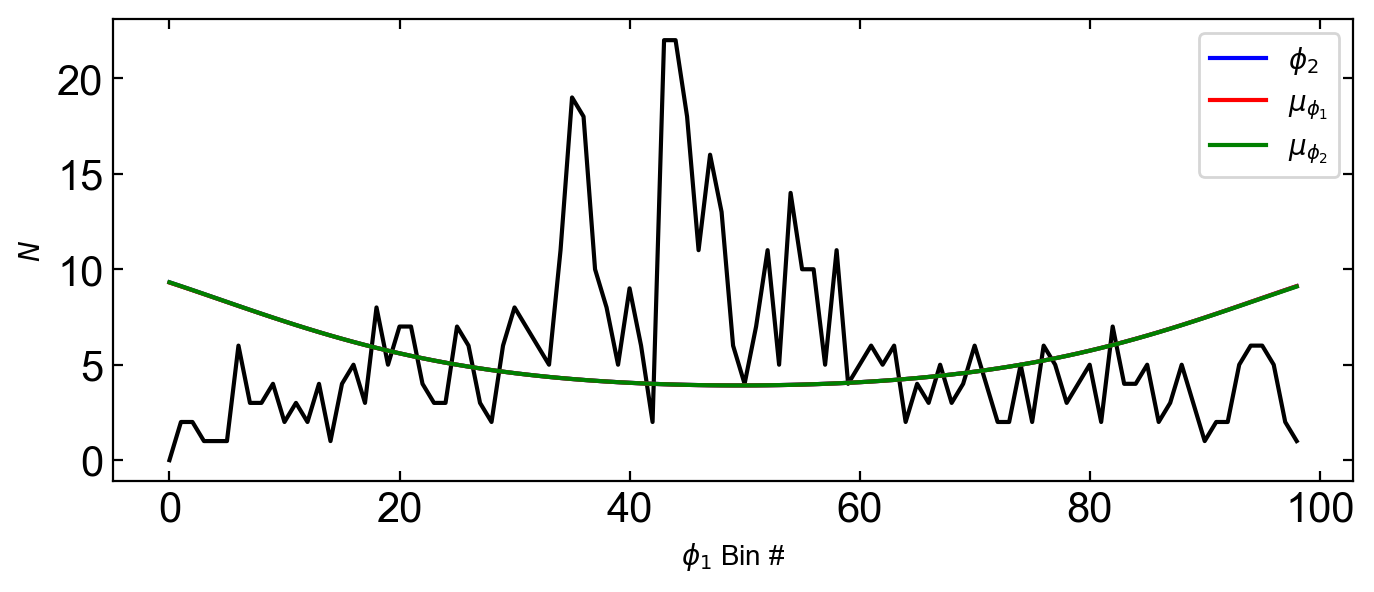

In [30]:
H_data1, *_ = np.histogram2d(
    stream_data["phi1"],
    stream_data["phi2"],
    bins=(stream_init.default_grids["phi1"], stream_init.default_grids['phi2'])
)

grids, ln_ns = stream_init.evaluate_on_2d_grids()

fig, ax1 = plt.subplots(1,1,figsize=(8, 3))
ax1.plot(H_data1.sum(axis=1), c='k')
ax1.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b', label=r'$\phi_2$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='r', label=r'$\mu_{\phi_1}$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='g', label=r'$\mu_{\phi_2}$')
ax1.set_xlabel(r'$\phi_1$ Bin #')
ax1.set_ylabel(r'$N$')
ax1.legend()
plt.show()

In [31]:
stream_init_p

{'ln_N': 6.335054251498059,
 'phi1': {'zs': array([0., 0., 0., 0., 0., 0., 0.])},
 'phi2': {'mean': array([-3.78141582, -0.82086845,  0.34829129,  0.99573059,  2.5570241 ]),
  'ln_std': array([0., 0., 0., 0., 0.])},
 'pm1': {'mean': array([-3.36999666, -3.83568809, -3.70443975, -3.95975724, -5.30168694]),
  'ln_std': array([-0.5, -0.5, -0.5, -0.5, -0.5])},
 'pm2': {'mean': array([-5.02225236, -3.8206049 , -3.13436217, -2.69513838, -2.2146856 ]),
  'ln_std': array([-0.5, -0.5, -0.5, -0.5, -0.5])}}

In [32]:
stream_opt_pars, info = stream_init.optimize(
    data=stream_data, init_params=stream_init_p, use_bounds=True, jaxopt_kwargs=dict(maxiter=4096),
)

stream_opt = StrModel(stream_opt_pars)
info

INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 2.258370814243102 Stepsize:1.0  Decrease Error:0.46091708699831835  Curvature Error:2.258370814243102 
INFO: jaxopt.ZoomLineSearch: Iter: 2 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.33450097435310117  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.5017514615296518  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:0.7526271922944776  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch: Iter: 1 Minimum Decrease & Curvature Errors (stop. crit.): 0.0 Stepsize:1.0  Decrease Error:0.0  Curvature Error:0.0 
INFO: jaxopt.ZoomLineSearch:

LbfgsbState(iter_num=Array(57, dtype=int64, weak_type=True), value=Array(-0.21013429, dtype=float64), grad={'ln_N': Array(1.11022302e-15, dtype=float64), 'phi1': {'zs': Array([ 0.00016794,  0.00019472,  0.00026273,  0.0007249 , -0.00036401,
       -0.00012851, -0.00047823], dtype=float64)}, 'phi2': {'ln_std': Array([ 5.23275736e-05,  4.93500292e-04, -1.05080420e-04, -6.55941980e-04,
        5.22215570e-06], dtype=float64), 'mean': Array([ 2.87036431e-04, -3.21376012e-04,  6.54076011e-04,  1.70358970e-04,
       -5.79156889e-07], dtype=float64)}, 'pm1': {'ln_std': Array([ 5.51464660e-04, -2.55875786e-05,  4.41134604e-04,  6.33624452e-04,
        3.17619504e-04], dtype=float64), 'mean': Array([ 1.54665550e-04, -4.63603302e-04, -4.37038525e-04, -3.67391060e-05,
        1.65535733e-04], dtype=float64)}, 'pm2': {'ln_std': Array([-3.27802126e-05, -3.20507921e-04,  3.83878987e-04,  2.90595292e-04,
       -2.05389759e-04], dtype=float64), 'mean': Array([-0.00042337,  0.00054152,  0.0002702 ,  

Text(0, 0.5, '$\\phi_2$')

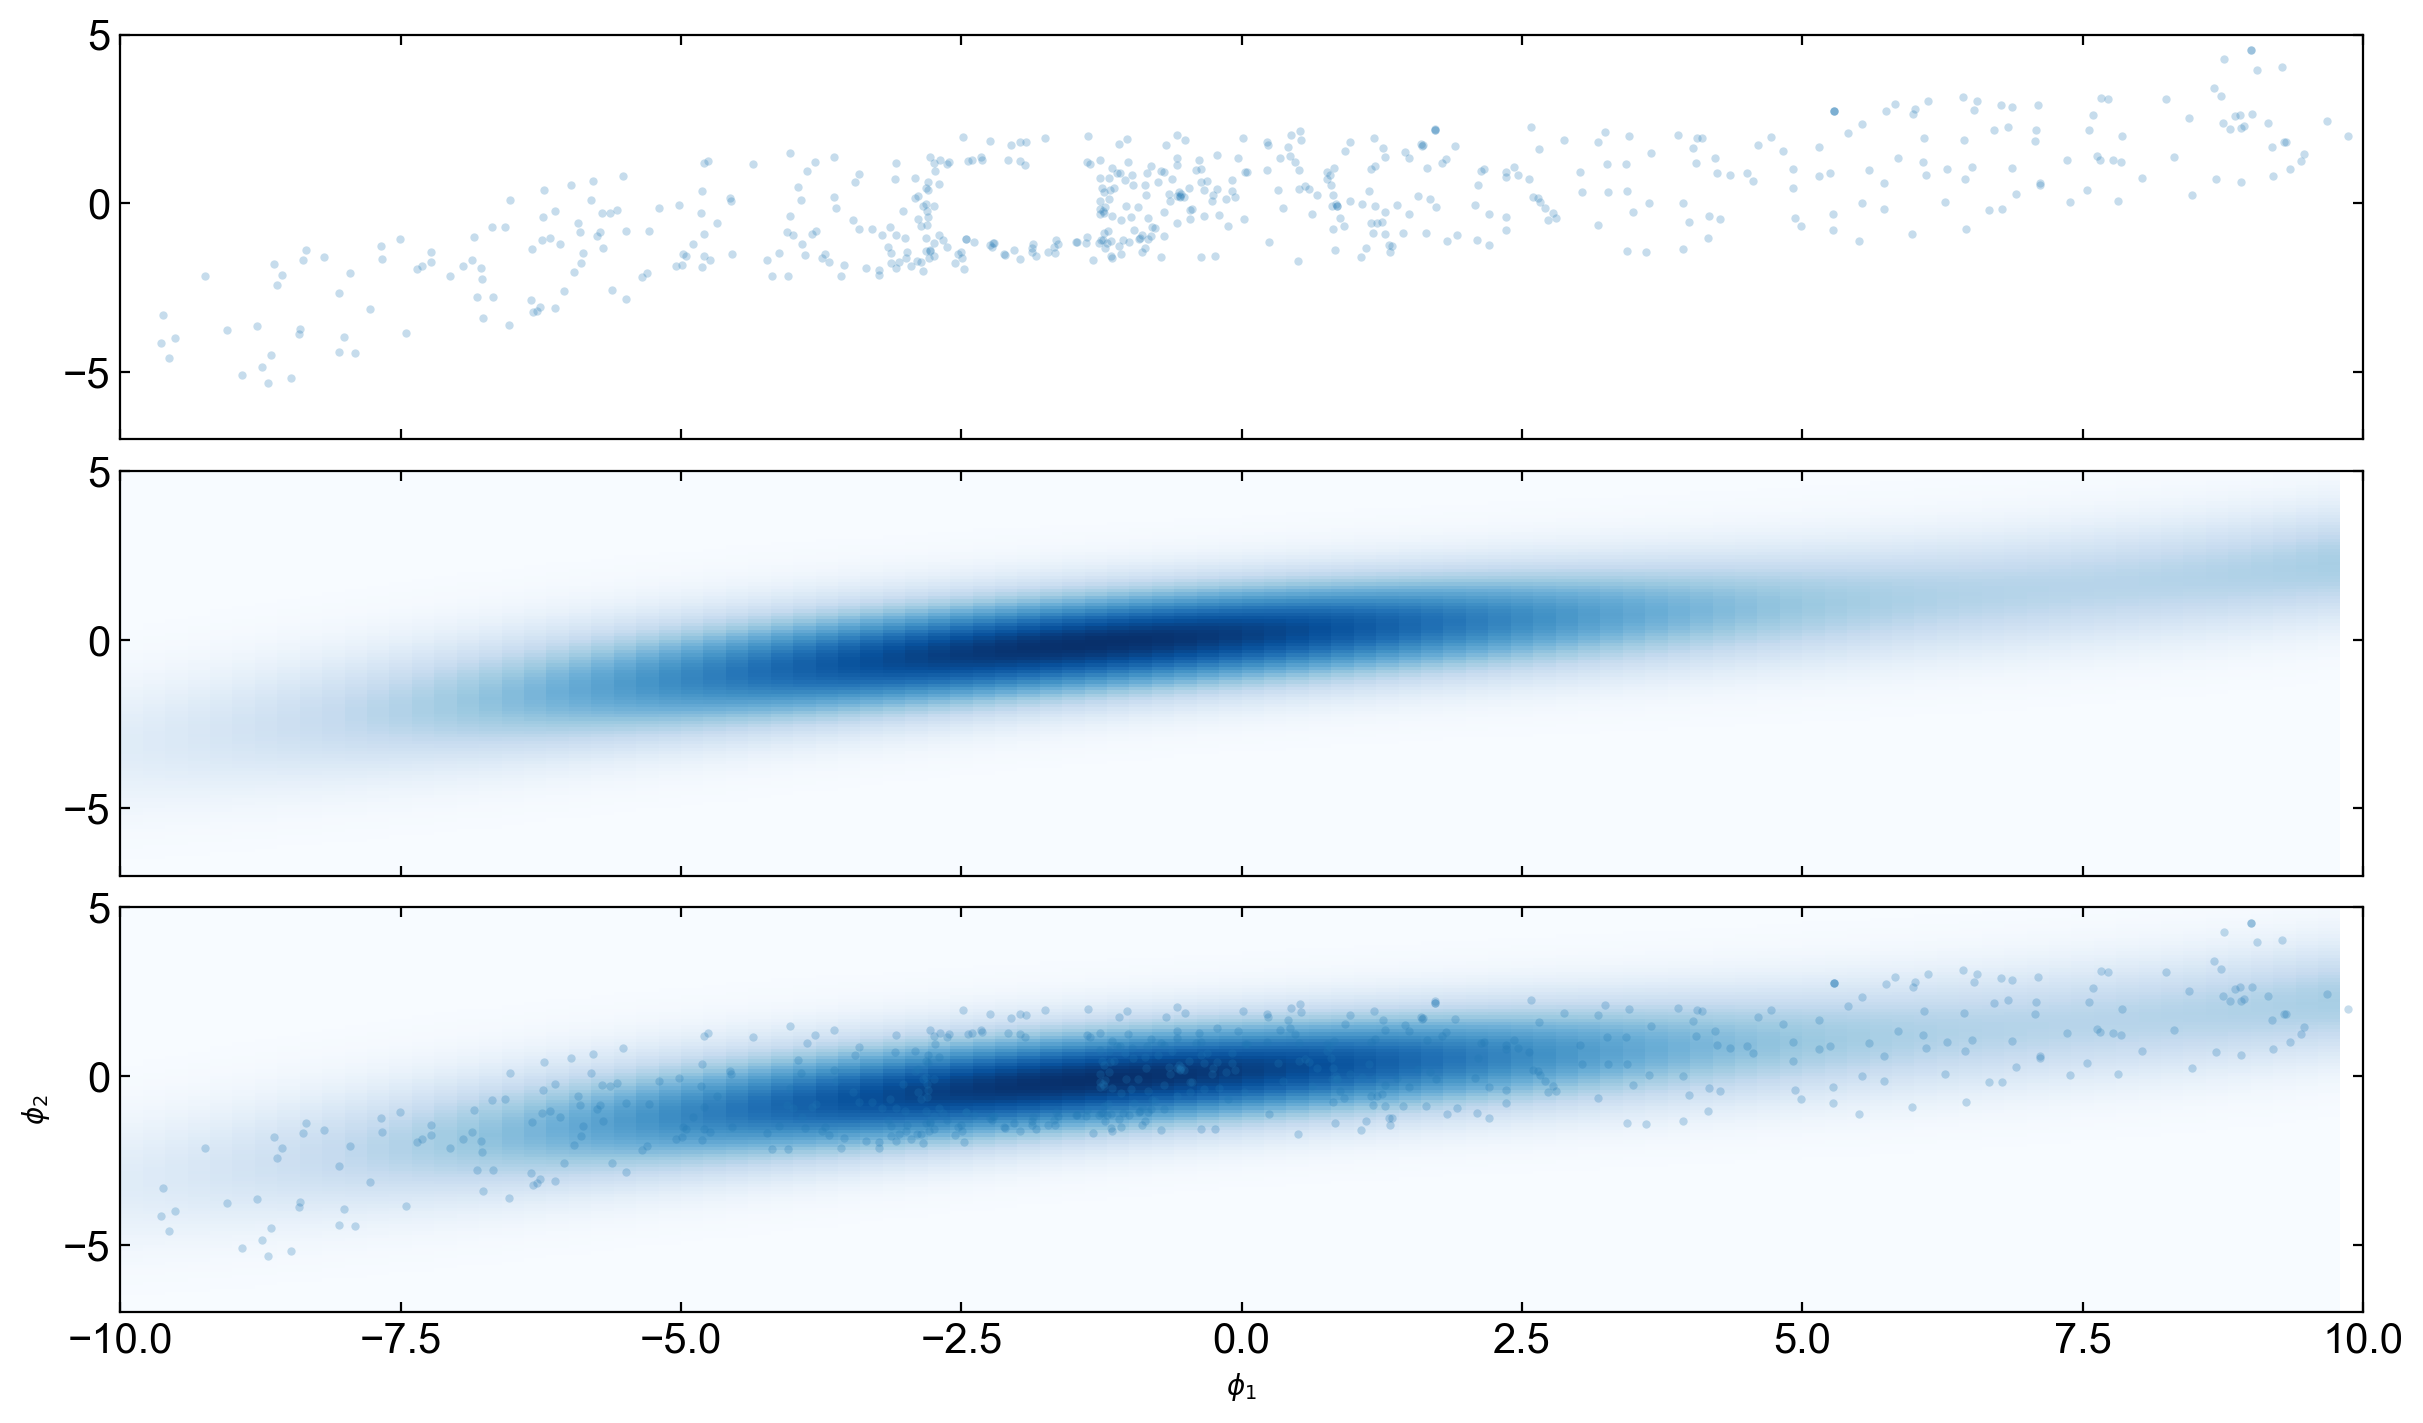

In [33]:
# _grids, ln_dens = GD1StreamModel(stream_init_p).evaluate_on_2d_grids()
_grids, ln_dens = stream_opt.evaluate_on_2d_grids()

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)

for ax in [axes[0], axes[2]]:
    ax.plot(
        stream_data['phi1'],
        stream_data['phi2'],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )
    
for ax in [axes[1], axes[2]]:
    ax.pcolormesh(
        _grids[('phi1', 'phi2')][0],
        _grids[('phi1', 'phi2')][1],
        np.exp(ln_dens[('phi1', 'phi2')]),
        cmap="Blues",
        shading='auto'
    )
ax.set_xlim(-10, 10)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

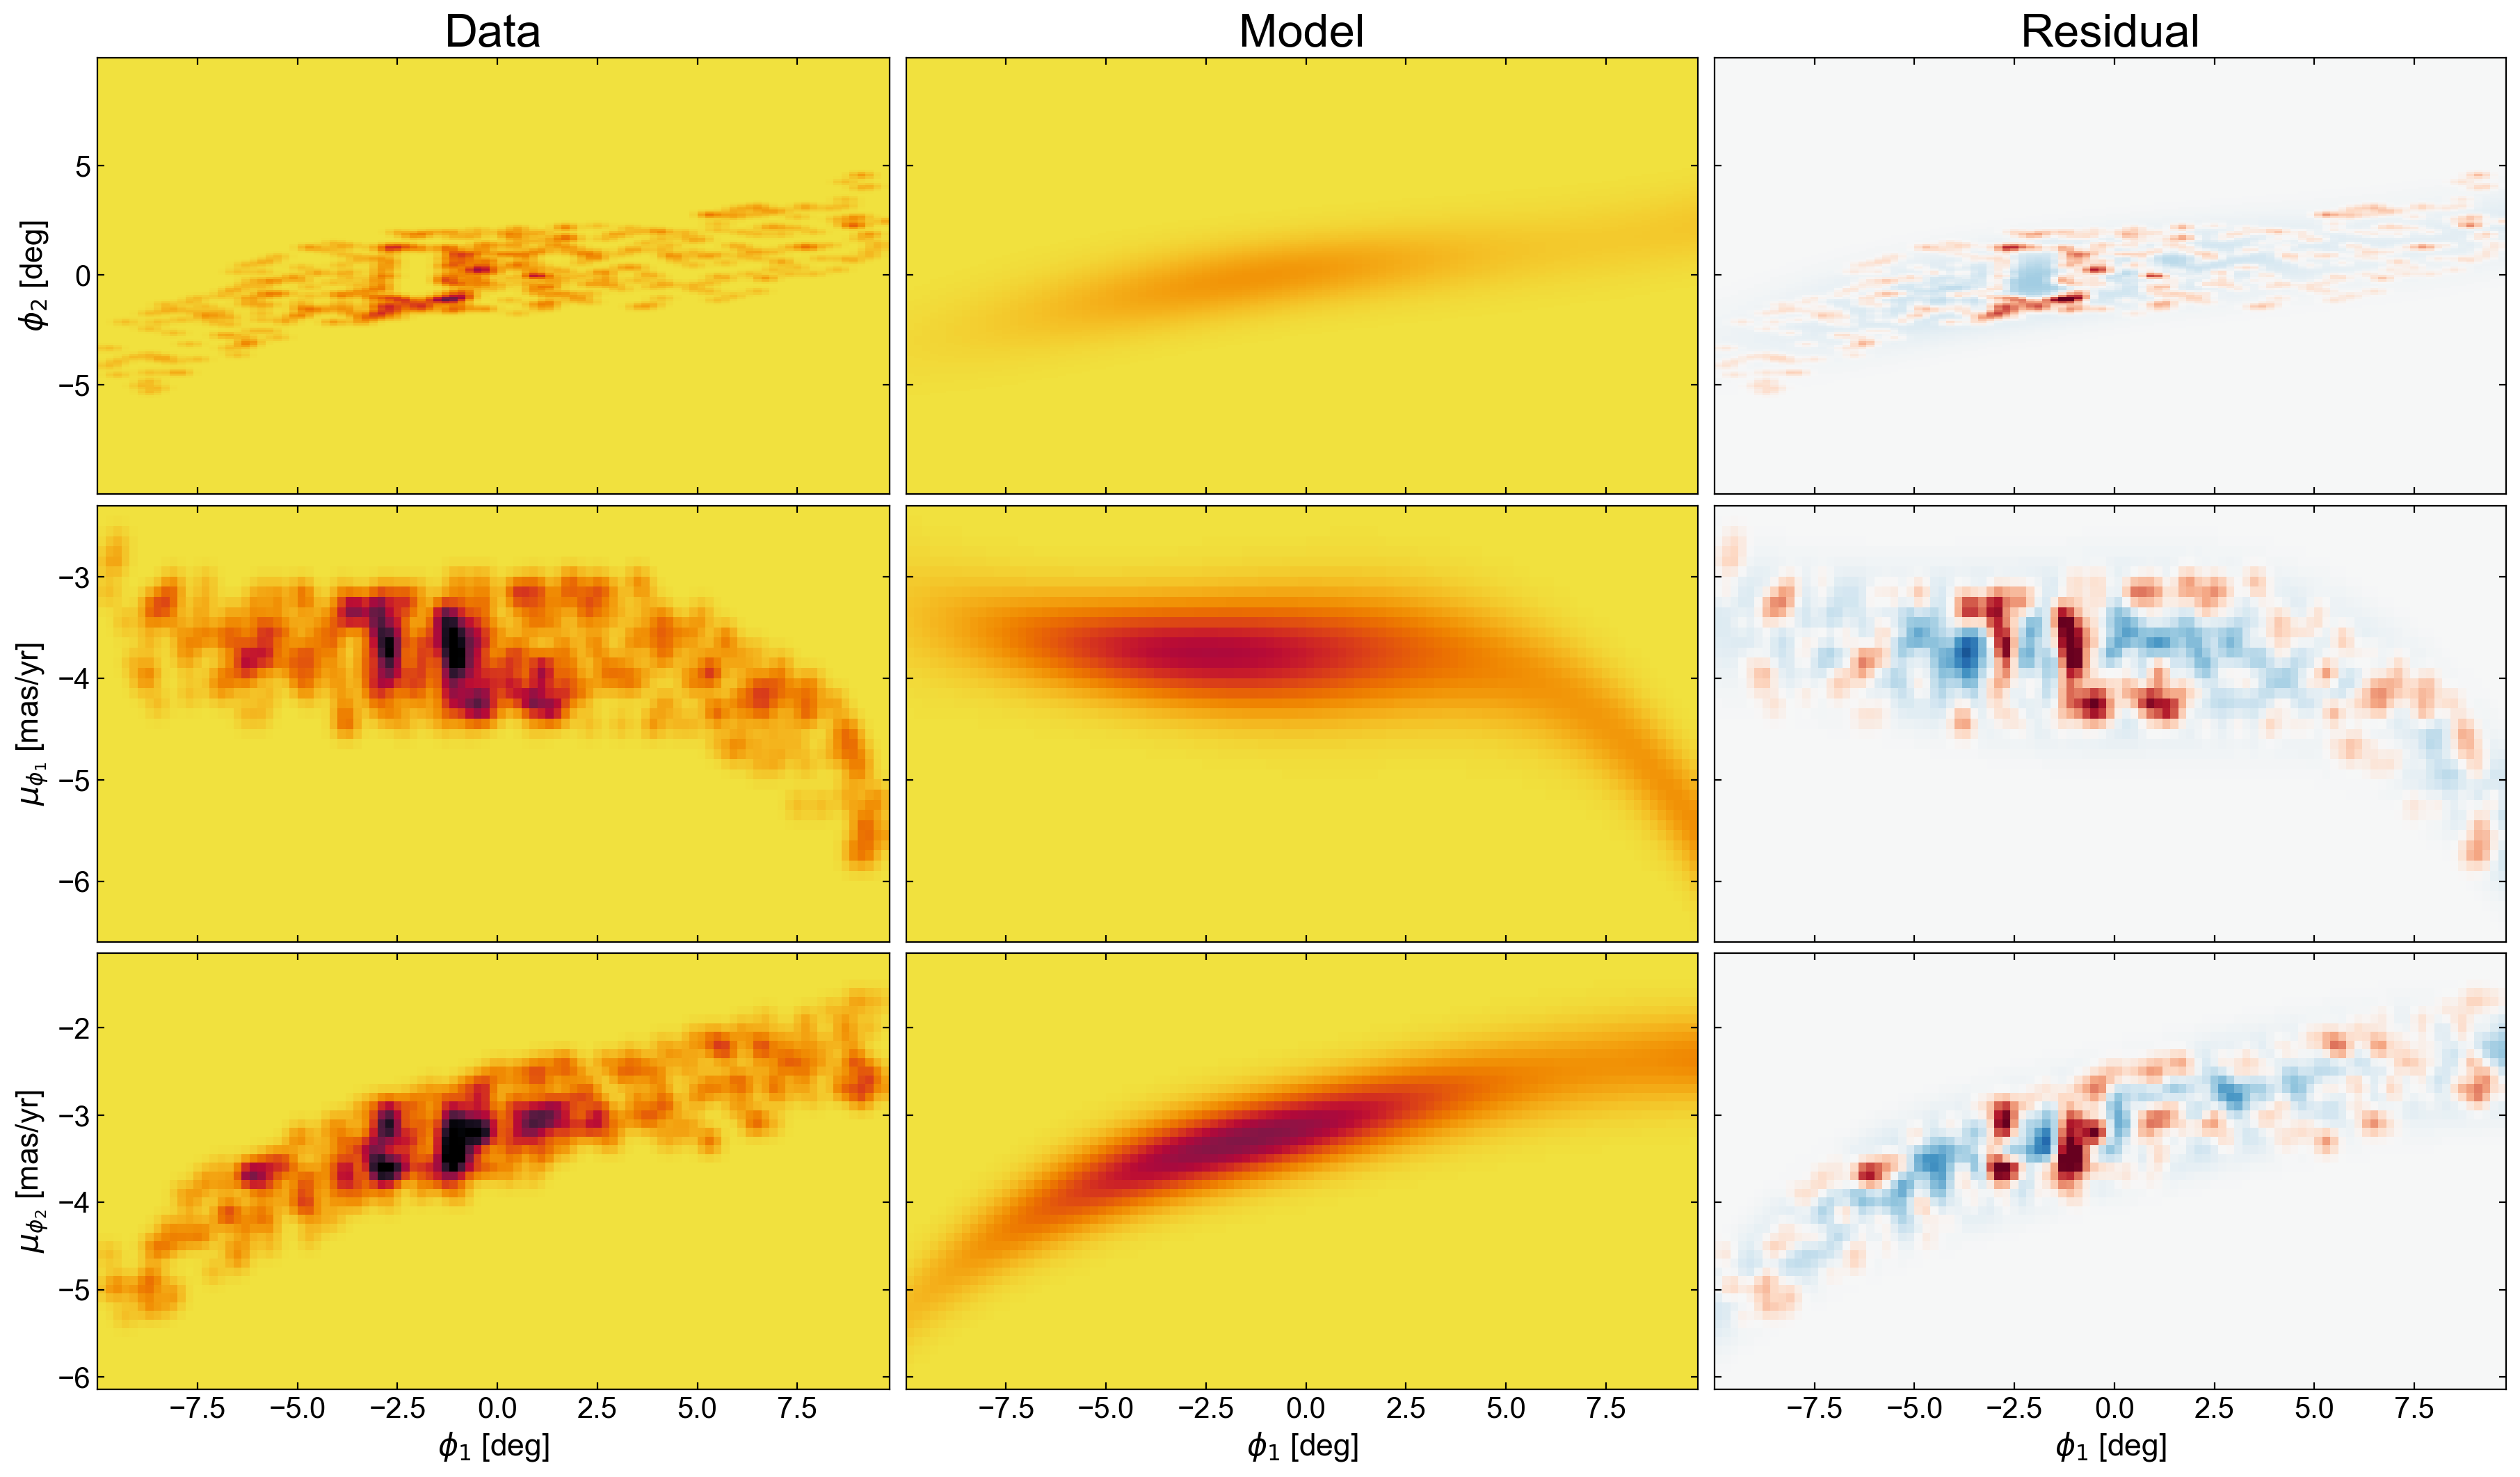

In [34]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=stream_data,
    grids=stream_opt.default_grids,
    axes=axes[:, 0],
    pcolormesh_kwargs=dict(rasterized=True, vmin=0, vmax=2)
)
stream_opt.plot_model_projections(axes=axes[:, 1], label=False, 
                                  pcolormesh_kwargs=dict(rasterized=True,vmin=0, vmax=2))
stream_opt.plot_residual_projections(
    data=stream_data, axes=axes[:, 2], label=False,
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu', rasterized=True)
)
axes[0][0].set_title('Data', fontsize=24)
axes[0][1].set_title('Model', fontsize=24)
axes[0][2].set_title('Residual', fontsize=24)
plt.show()

# Mixture of Stream + Background (no off-track)

The problem with this is that the background model is not 2D so there is a lot of excess in certain parts that are being tracked as off-track features in this section.

In [35]:
Components = [StrModel, BkgModel]
MixModel_NoOff = make_mixture_model(StreamMixtureModel, Components)

In [36]:
mix_params0 = {"stream": stream_opt_pars, "background": bkg_opt_pars}
mix_params0['background']['ln_N'] = np.log(len(run_data['phi1']) - np.exp(mix_params0['stream']['ln_N']))

mix_init = MixModel_NoOff(mix_params0)

In [37]:
mix_opt_pars, info = MixModel_NoOff.optimize(
    data=run_data, init_params=mix_params0, use_bounds=True,
    jaxopt_kwargs=dict(maxiter=4096)
)

mix_opt = MixModel_NoOff(mix_opt_pars)
info

ScipyMinimizeInfo(fun_val=Array(-0.52551195, dtype=float64, weak_type=True), success=True, status=0, iter_num=1494, hess_inv=LbfgsInvHessProduct(sk=[[-3.88934333e-06  2.02711586e-04 -1.95175046e-04 ... -2.60086856e-04
  -6.46467706e-05  1.41333895e-04]
 [ 4.58462182e-05  1.93957676e-04 -1.70871466e-04 ... -3.63452673e-05
  -5.23606990e-05  1.60166890e-04]
 [-3.63253853e-05  6.86167949e-05 -1.13617704e-04 ... -1.14212736e-04
  -4.19749411e-05  2.95714753e-05]
 ...
 [ 4.01888164e-05  1.10634225e-04 -1.14766066e-04 ...  8.27870913e-05
  -2.89163473e-05  1.35080546e-04]
 [ 1.13778132e-05  1.36066744e-04 -4.72260085e-05 ... -1.20445746e-04
  -2.96829396e-05  8.70054727e-05]
 [ 1.29500396e-05  2.32867772e-04 -8.45922783e-05 ... -2.00589710e-04
  -4.70385085e-05  1.44531735e-04]], yk=[[-4.77375900e-06  6.29507908e-07  4.30381410e-07 ... -5.60005908e-06
  -1.33293178e-07  5.21013999e-07]
 [ 4.44988286e-05  1.10340700e-06  9.02925880e-07 ... -8.90970107e-07
   1.72841490e-07  4.35803762e-07]
 [

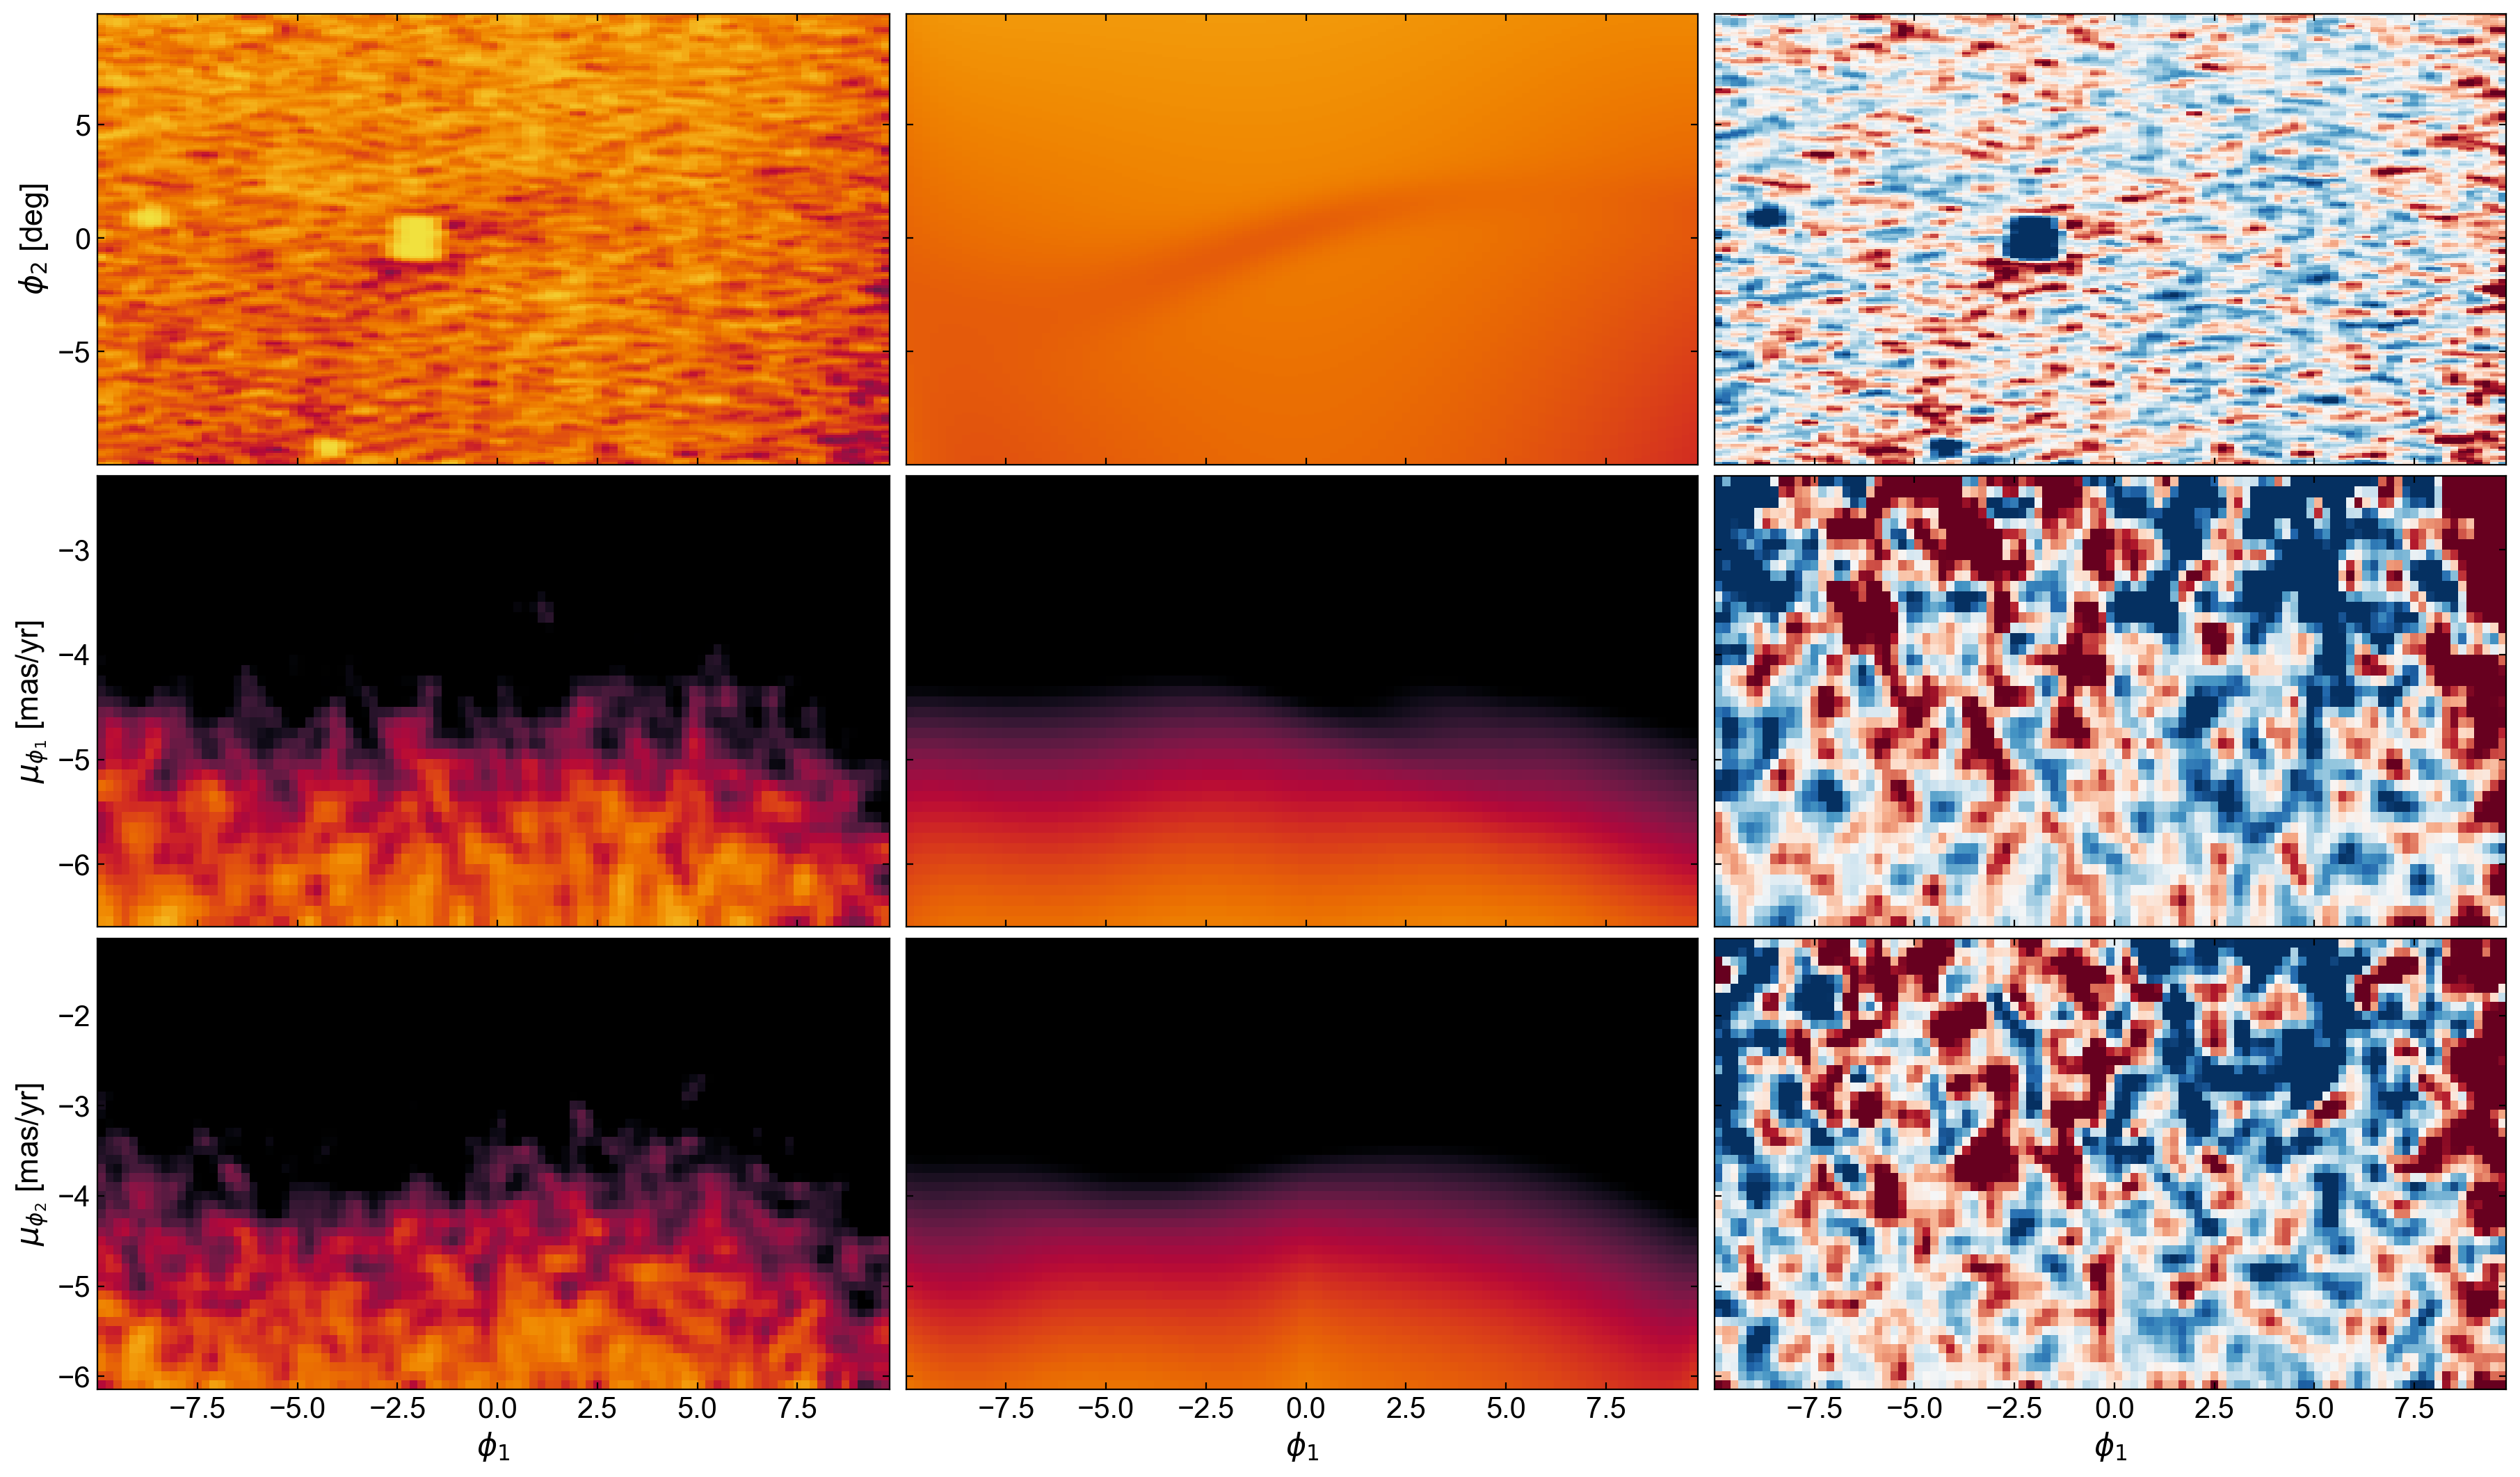

In [38]:
fig, axes = plt.subplots(
    len(mix_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(mix_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=mix_opt.default_grids,
    axes=axes[:, 0],
    pcolormesh_kwargs=dict(rasterized=True, vmin=0, vmax=5)
)
mix_opt.plot_model_projections(axes=axes[:, 1], label=False,
                              pcolormesh_kwargs=dict(rasterized=True, vmin=0, vmax=5))
mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], label=False,
    pcolormesh_kwargs=dict(vmin=-1, vmax=1, cmap='RdBu')
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Off-track

In [39]:
import importlib
importlib.reload(sys.modules['gd1_helpers.membership'])
importlib.reload(sys.modules['gd1_helpers.membership.gd1_model'])
importlib.reload(sys.modules['stream_membership'])
importlib.reload(sys.modules['scripts.m92_init'])
from gd1_helpers.membership.gd1_model import (
    Base,
    BackgroundModel,
    StreamDensModel,
    OffTrackModel,
)
from scripts.m92_init import make_offtrack_model
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections

In [40]:
OffModel = make_offtrack_model(OffTrackModel, p, cat, dens_steps=np.array([0.4,0.2]), StrModel=StrModel)

In [41]:
OffModel.dens_phi1_lim

(-9.999980987480058, 9.999999939931278)

In [42]:
offtrack_init_p = {
    "ln_N": np.log(50),
    ("phi1", "phi2"): {
        "zs": np.zeros(OffModel.phi12_locs.shape[0] - 1)
    },
    "pm1": stream_opt_pars["pm1"].copy(),
    "pm2": stream_opt_pars["pm2"].copy()
}

In [ ]:
offtrack_init = OffModel(offtrack_init_p)
_ = offtrack_init.plot_model_projections(grid_coord_names=[('phi1', 'phi2')])

# Mixture of all components

In [43]:
full_Components = [StrModel, BkgModel, OffModel]
full_mix_params0 = {
    "stream": mix_opt_pars['stream'],
    "background": mix_opt_pars['background'],
    "offtrack": offtrack_init_p,
}

MixModel = make_mixture_model(StreamMixtureModel, full_Components)

In [44]:
tied_params = [
    (("offtrack", "pm1"), ("stream", "pm1")),
    (("offtrack", "pm2"), ("stream", "pm2")),
]
full_mix_init = MixModel(
    full_mix_params0, tied_params=tied_params
)

In [ ]:
full_mix_opt_pars, info = MixModel.optimize(
    data=run_data,
    tied_params=tied_params,
    init_params=full_mix_params0,
    use_bounds=False,
)

full_mix_opt = MixModel(full_mix_opt_pars)
info

In [ ]:
import copy
tmp_pars = copy.deepcopy(full_mix_opt_pars['offtrack'])
tmp_pars['pm1'] = full_mix_opt_pars['stream']['pm1'].copy()
tmp_pars['pm2'] = full_mix_opt_pars['stream']['pm2'].copy()
tmp = OffTrackModel(tmp_pars)
_,_,pcms = tmp.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], label=False, 
    pcolormesh_kwargs=dict(vmin=0, vmax=0.2, cmap='cmr.ember_r')
)

In [ ]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=1, cmap='cmr.ember_r')
)

In [77]:
stream_comp, bkg_comp, offtrack_comp = full_mix_opt.components[0], full_mix_opt.components[1], full_mix_opt.components[2]
stream_ll = -np.log(stream_comp.get_N()) + stream_comp.ln_number_density(run_data)
bkg_ll = -np.log(bkg_comp.get_N()) + bkg_comp.ln_number_density(run_data)
offtrack_ll = -np.log(offtrack_comp.get_N()) + offtrack_comp.ln_number_density(run_data)

#one way
fg_ll = np.logaddexp(stream_ll, offtrack_ll)

#another way
# fg_comps = full_mix_nobkg_opt.components
# fg_ll_ = -np.log(fg_comps[0].get_N() + fg_comps[1].get_N()) + full_mix_nobkg_opt.ln_number_density(run_data)

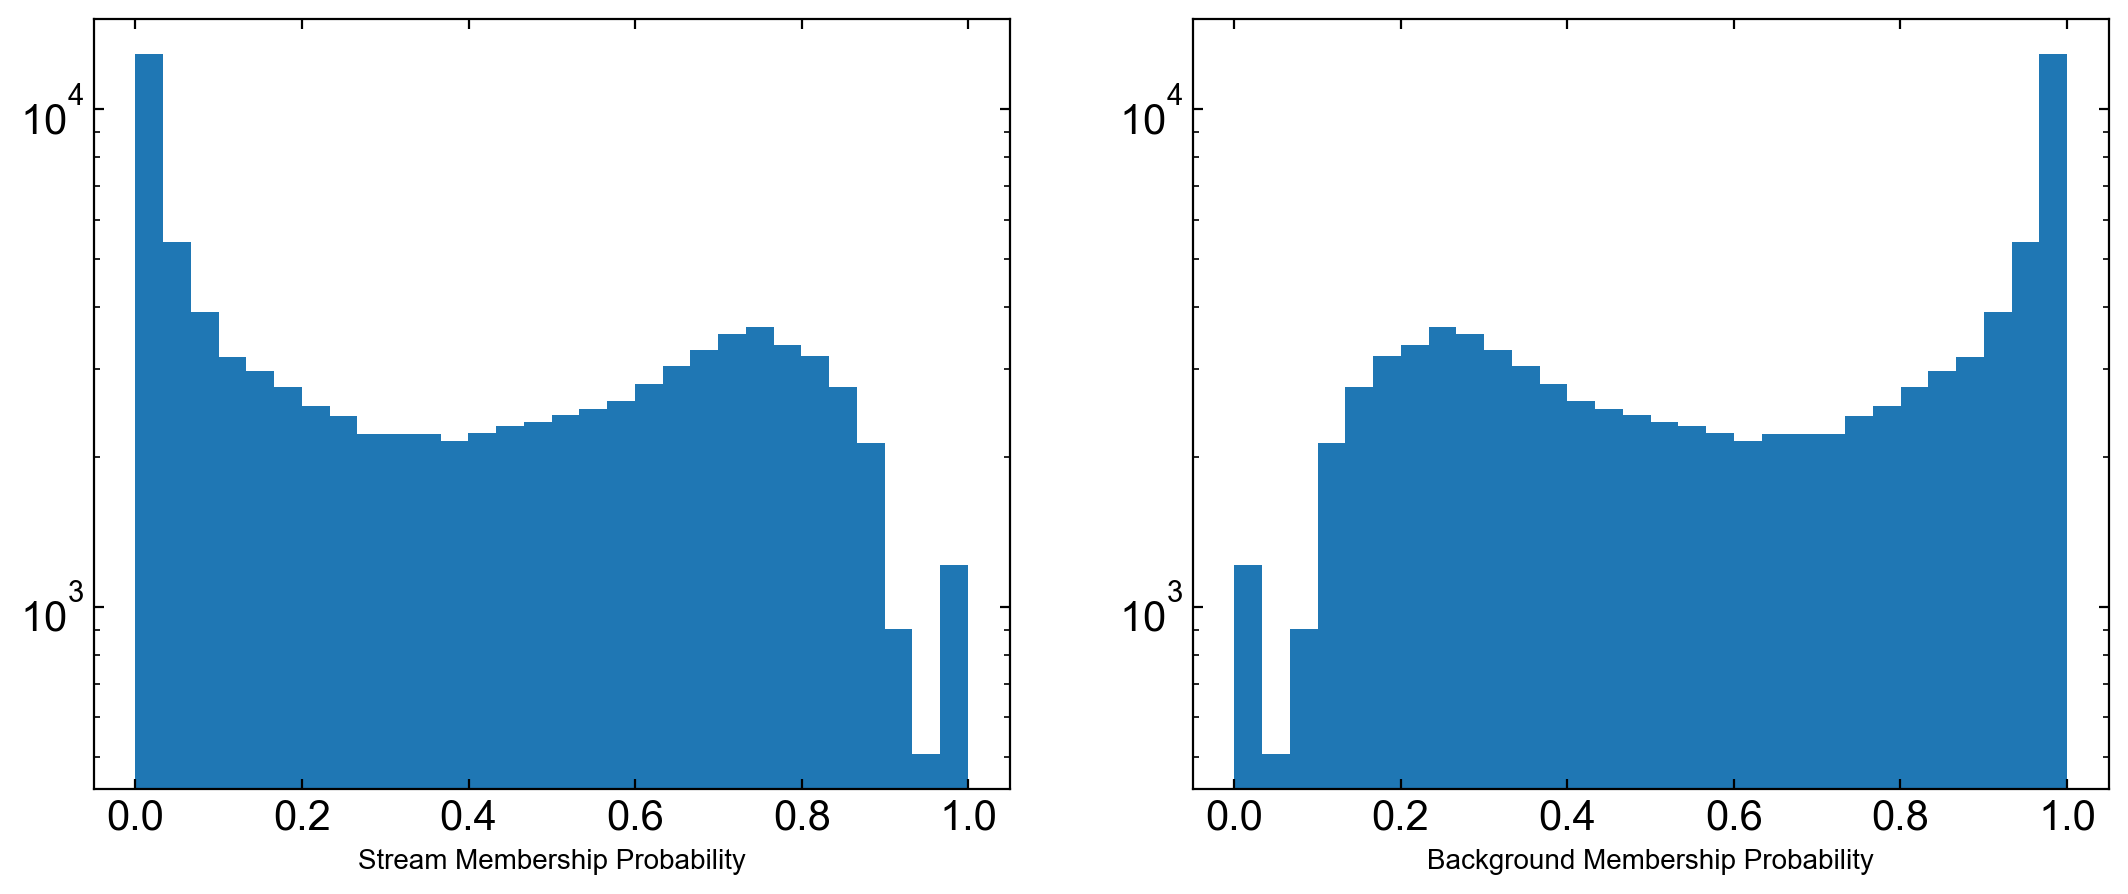

In [78]:
final_memb_prob = np.exp(fg_ll - np.logaddexp(fg_ll,bkg_ll)) #update for offtrack included
bkg_prob = np.exp(bkg_ll - np.logaddexp(fg_ll,bkg_ll))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5))
ax1.hist(final_memb_prob, bins=30)
ax1.set_yscale('log')
ax1.set_xlabel('Stream Membership Probability')

ax2.hist(bkg_prob, bins=30)
ax2.set_xlabel('Background Membership Probability')
ax2.set_yscale('log')
plt.show()

TODO: how to plot projections for components where the x coord is in a joint, like OffTrack?

Text(0, 0.5, '$\\phi_2$')

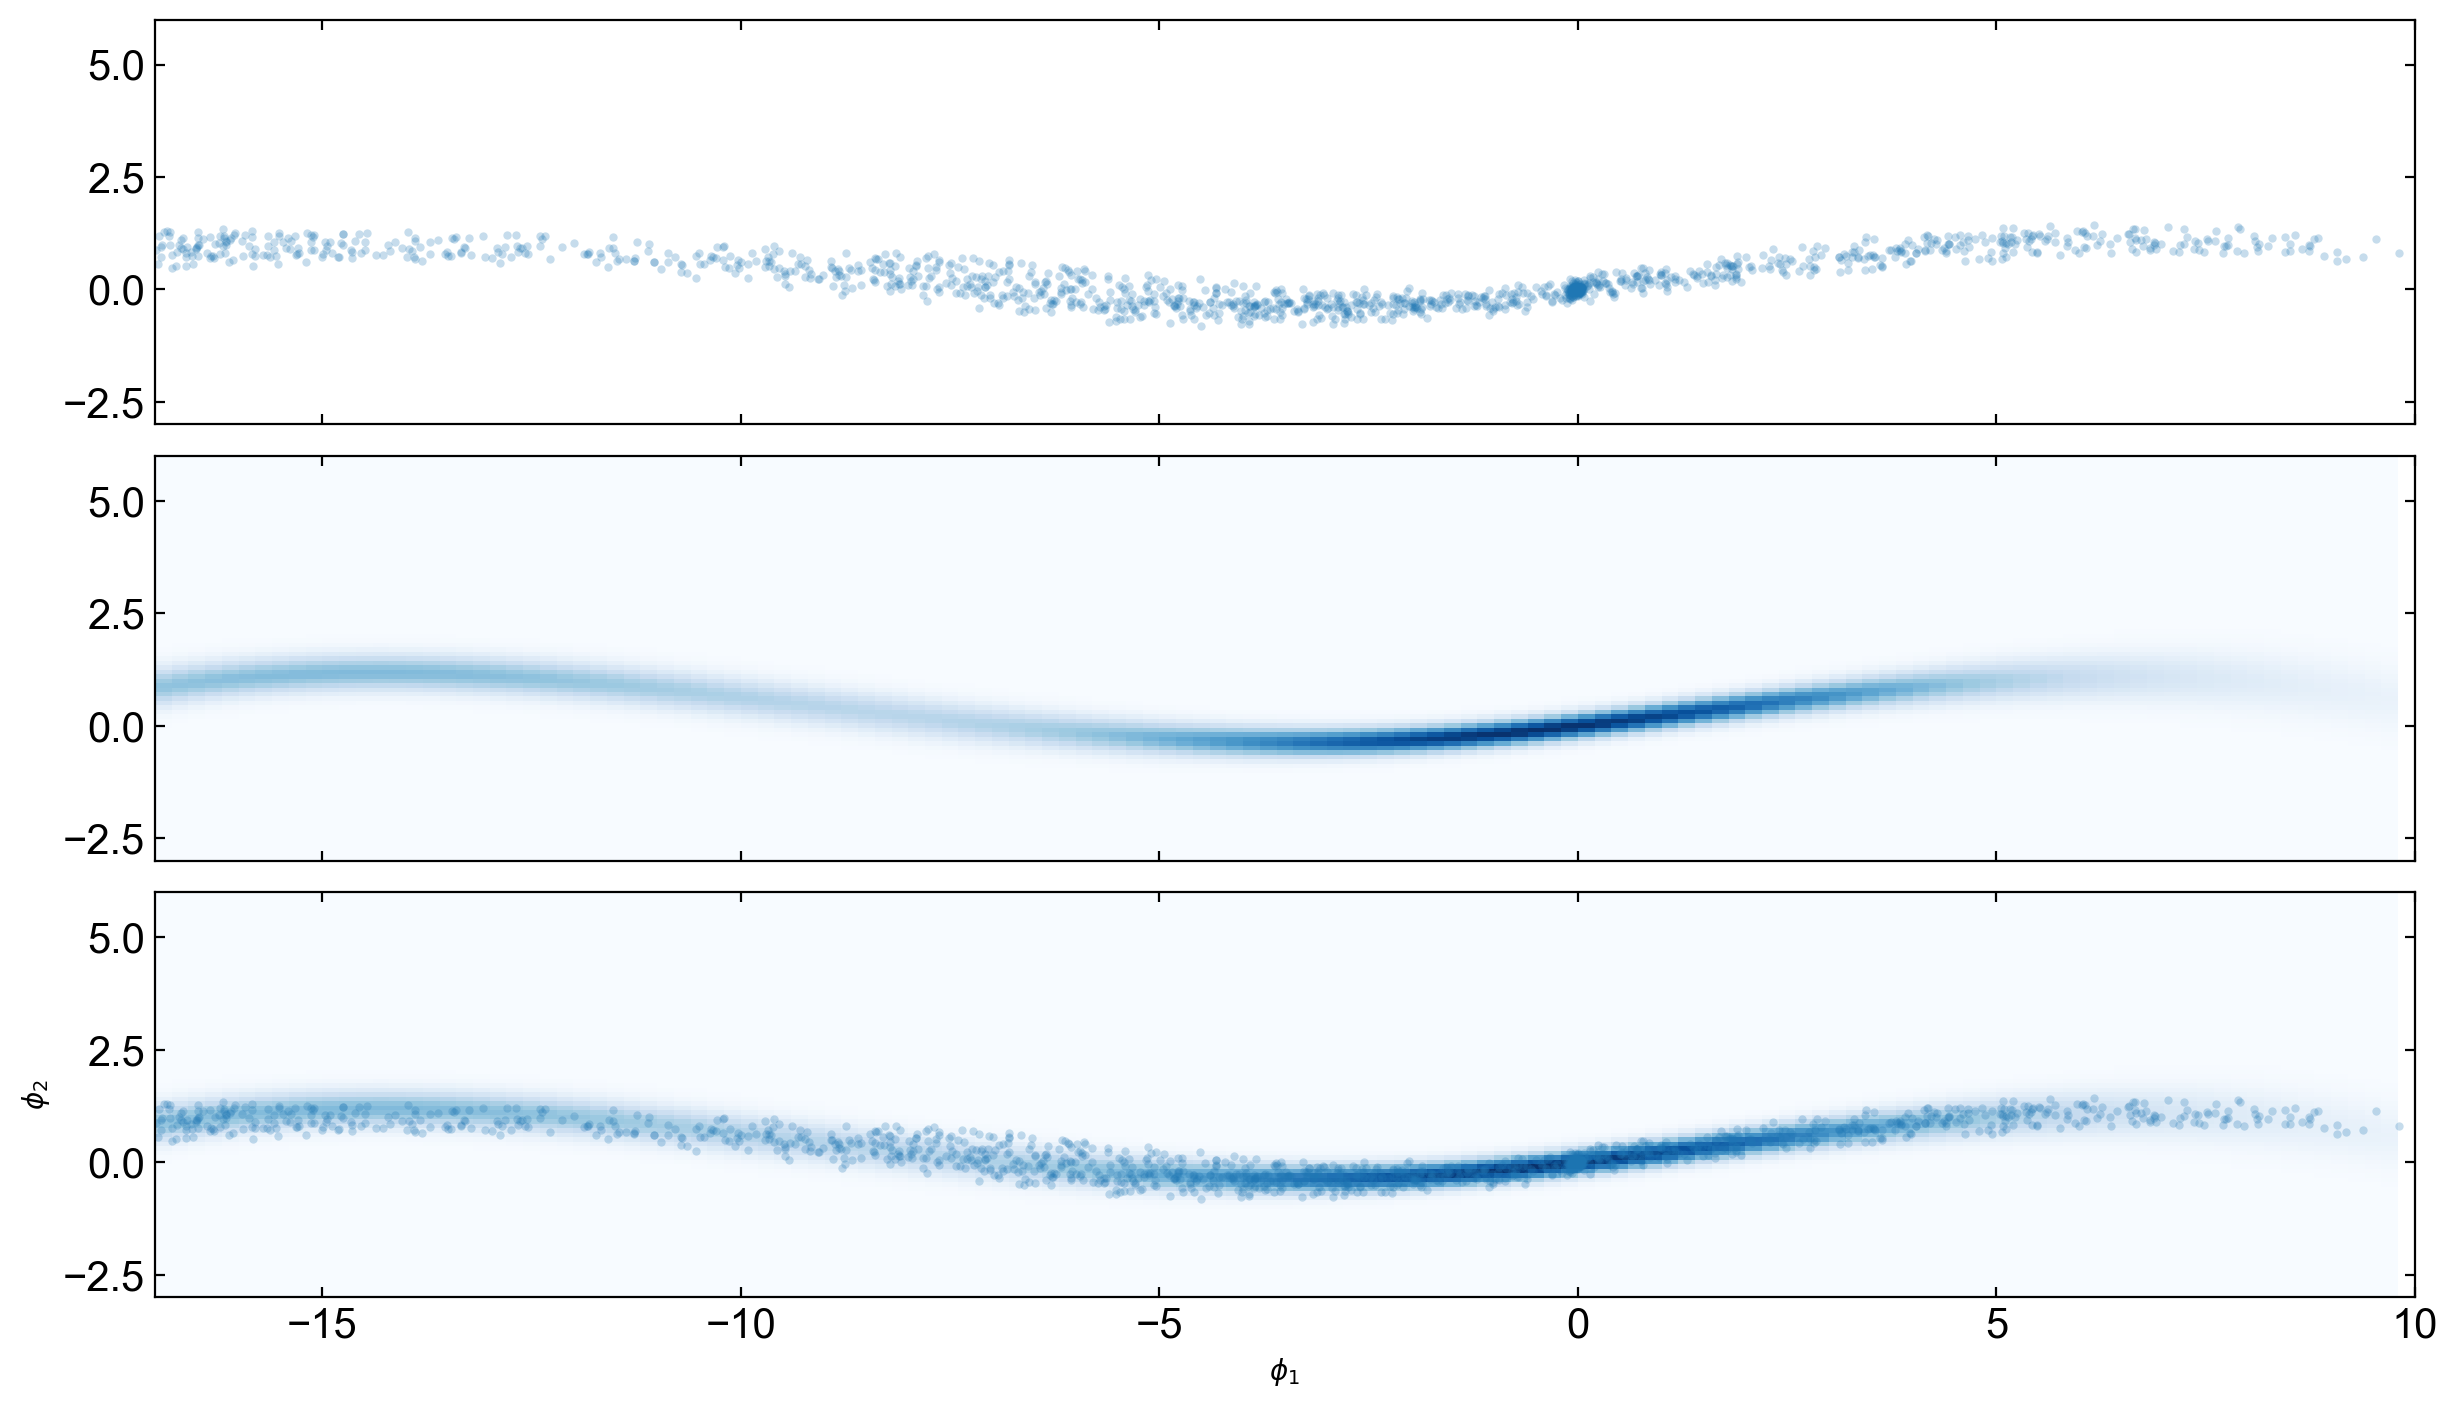

In [86]:
threshold = (final_memb_prob>0.95)

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)
for ax in [axes[0], axes[2]]:
    ax.plot(
        run_data['phi1'][threshold],
        run_data['phi2'][threshold],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )
    
for ax in [axes[1], axes[2]]:
    ax.pcolormesh(
        _grids[('phi1', 'phi2')][0],
        _grids[('phi1', 'phi2')][1],
        np.exp(ln_dens[('phi1', 'phi2')]),
        cmap="Blues",
        shading='auto'
    )
ax.set_xlim(-17, 10)
ax.set_ylim(-3, 6)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")